# import packges

In [2]:
library(DESeq2)
library(data.table)
library(dplyr)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(clusterProfiler)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(ggplot2)
library(gridExtra)
library(RColorBrewer)
library(IRdisplay)
library(GGally)
library(ChIPpeakAnno)
library(universalmotif)
library(IRdisplay)
library(ggpubr)
library(DiffBind)
library(kableExtra)
library(tidyverse)
library(ggraph)
library(tidygraph)
library(readxl)
library(corrplot)
library(ggrepel)
library(msigdbr)
library(fgsea)
library(ggvenn)
library(ComplexHeatmap)
library(ggVennDiagram)
library(venneuler)
library(sva)
library(DT)
library(tools)
library(tidyverse)
library(RSQLite)

library(edgeR)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

source('~/script/utils.r')


In [3]:
blue_meth_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/DNA_Methylation/Blueprint_dataset_EGAD00001002732/'
base_dir = '~/WenhuoHu/collab_Farhan/'
setwd(base_dir)


# dsn table

In [5]:
tbl1 = fread(paste0(blue_meth_dir, 'meta_EGAD00001002732/sample_file.tsv')) 
dim(tbl1)
head(tbl1)


[1] 639   4

sample_accession_id,sample_alias,file_name,file_accession_id
<chr>,<chr>,<chr>,<chr>
EGAN00001447379,10_11,MLP3_1000_D2_R2.bam,EGAF00001382489
EGAN00001447379,10_11,MLP3_10_D2_1_R2.bam,EGAF00001382498
EGAN00001447379,10_11,MLP3_10_D2_2_R2.bam,EGAF00001382499
EGAN00001447379,10_11,MLP3_10_D2_3_R2.bam,EGAF00001382500
EGAN00001447379,10_11,MLP3_10_D2_4_R2.bam,EGAF00001382501
EGAN00001447379,10_11,MLP3_10_D2_5_R2.bam,EGAF00001382502


In [6]:
tbl2 = fread(paste0(blue_meth_dir, 'meta_EGAD00001002732/samples.tsv'))
dim(tbl2) 
head2(tbl2) 

[1] 63 11

accession_id,alias,title,description,biological_sex
<chr>,<chr>,<chr>,<chr>,<chr>
EGAN00001447379,10_11,"donor #10, MLP3, peripheral_blood",Immature lymphoid progenitor 3 from peripheral blood,male
EGAN00001447380,11_11,"donor #11, MLP3, peripheral_blood",Immature lymphoid progenitor 3 from peripheral blood,male
EGAN00001447381,12_7,"donor #12, CLP, peripheral_blood",Common lymphoid progenitor from peripheral blood,male


In [7]:
nrow(tbl1[!duplicated(sample_accession_id), ])

[1] 63

In [8]:
dsn = merge(tbl1, tbl2, by.x = 'sample_accession_id', by.y = 'accession_id', all.x = T)
dsn[, bam_ori_file := paste0(blue_meth_dir, file_accession_id, '/', file_name) ]
dsn[, sample_name := file_accession_id]
dsn[, sample_pre := paste0(blue_meth_dir, file_accession_id, '/', file_accession_id, '_') ]
dsn[, sample_dir := paste0(blue_meth_dir, file_accession_id, '/') ]
dsn[, cell_type := sub('_.*', '', file_name) ]
dsn[, donor := sub('.*(D.*?)_.*', '\\1', file_name) ]
    

In [9]:
dsn[, ctype_donor := paste0(cell_type, '_', donor)]

In [10]:
length(table(dsn[, ctype_donor]))

[1] 59

In [11]:
dim(dsn)

[1] 639  21

In [12]:
dsn$bam_ori_file[1]


[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/DNA_Methylation/Blueprint_dataset_EGAD00001002732/EGAF00001382489/MLP3_1000_D2_R2.bam"

In [19]:
all(file.exists(dsn$bam_ori_file)) 

[1] TRUE

# bam to fastq

In [20]:
# the files were name sorted
# samtools view -H bam_file

In [12]:
# it automatically comrpess it when file name end with .gz
dsn[, fq_1 := paste0(sample_pre, 'r1.fastq.gz')]
dsn[, fq_2 := paste0(sample_pre, 'r2.fastq.gz')]

dsn[, sorted_bam_file := bam_ori_file ]
dsn[, bam2fq_jobname := paste0('bam2fq_', sample_name) ]
dsn[, bam2fq_oo := paste0(sample_pre, '_bam2fq.out')]
dsn[, bam2fq_er := paste0(sample_pre, '_bam2fq.err')]
dsn[, bam2fq_cmd := paste0('bsub -J ', bam2fq_jobname, ' -n 5 -o ', bam2fq_oo, ' -e ', bam2fq_er, ' -P beat -n 2 -R "rusage[mem=5GB]" ')]
dsn[, bam2fq_cmd := paste0(bam2fq_cmd, ' " singularity exec /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/images/depot.galaxyproject.org-singularity-picard-3.0.0--hdfd78af_1.img ')]
dsn[, bam2fq_cmd := paste0(bam2fq_cmd, ' picard SamToFastq -INPUT ', sorted_bam_file, ' --FASTQ ', fq_1, ' --SECOND_END_FASTQ ', fq_2, '"') ]
write(dsn[, bam2fq_cmd], file = 'run_bismark_bam2fq.sh')


# make genome

In [22]:
# bismark_genome_preparation /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/genomes/t2t/ 

# run bismark alignment

In [13]:
proj_meth = 'bismark'

In [14]:
source('~/script/utils.r')

In [15]:
gnome = genome_fun('t2t')

In [16]:
# module load bismark/2.7.10a
REFERENCE_GENOME="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF"
REFERENCE_GENOME_FASTA='/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.fa'
GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf"
TE_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf"
bismark_genome = "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/genomes/t2t/"


dsn[, bismark_jobname := paste0('bismark_', sample_name, '_', proj_meth)]
dsn[, bismark_oo := paste0(sample_pre, 'bismark_out')]
dsn[, bismark_eo := paste0(sample_pre, 'bismark_err')]
dsn[, bam_prefix := paste0(sample_pre, '_')]
dsn[, bam_file := paste0(sample_pre, 'r1_bismark_bt2_pe.bam')]
#EGAF00001382429_r1_bismark_bt2_pe.bam

dsn[, bismark_cmd := paste0('bsub -J ', bismark_jobname, ' -o ', bismark_oo, ' -e ', bismark_eo)]
dsn[, bismark_cmd := paste0(bismark_cmd, ' -n 20  -R "span[hosts=1]" -R "rusage[mem=10GB]" ')]
dsn[, bismark_cmd := paste0(bismark_cmd, ' -W 240:00')]
dsn[, bismark_cmd := paste0(bismark_cmd, ' " bismark ')] 
dsn[, bismark_cmd := paste0(bismark_cmd, ' --parallel 19 --gzip -o ', sample_dir) ]
dsn[, bismark_cmd := paste0(bismark_cmd, ' --genome_folder ', bismark_genome, ' -1 ', fq_1, ' -2 ', fq_2,  ' "') ]

#write(dsn[cell_type %in% c('HSC', 'CMP', 'GMP', 'Mono', 'Neu'), bismark_cmd], file = paste0(base_dir, 'script/run_bismark_bismark.sh'))
write(dsn[!file.exists(bam_file), bismark_cmd], file = paste0(base_dir, 'run_bismark_bismark.sh'))


In [17]:
dsn[cell_type %in% c('HSC', 'CMP', 'GMP', 'Mono', 'Neu'), bismark_cmd][1]

[1] "bsub -J bismark_EGAF00001382429_bismark -o /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/DNA_Methylation/Blueprint_dataset_EGAD00001002732/EGAF00001382429/EGAF00001382429_bismark_out -e /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/DNA_Methylation/Blueprint_dataset_EGAD00001002732/EGAF00001382429/EGAF00001382429_bismark_err -n 20  -R \"span[hosts=1]\" -R \"rusage[mem=10GB]\"  -W 240:00 \" bismark  --parallel 19 --gzip -o /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/DNA_Methylation/Blueprint_dataset_EGAD00001002732/EGAF00001382429/ --genome_folder /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/genomes/t2t/ -1 /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/DNA_Methylation/Blueprint_dataset_EGAD00001002732/EGAF00001382429/EGAF00001382429_r1.fastq.gz -2 /research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/DNA_Methylation/Blueprint_dataset_EGAD00001002732/EGAF00001382429/EGAF00001382429_r2.fastq.gz \""

# bismark report

In [18]:
dsn[, bisext_jobname := paste0('bisext_', sample_name, '_', proj_meth)]
dsn[, bisext_oo := paste0(sample_pre, 'bisext_out')]
dsn[, bisext_eo := paste0(sample_pre, 'bisext_err')]

dsn[, bisext_cmd := paste0('bsub -J ', bisext_jobname, ' -o ', bisext_oo, ' -e ', bisext_eo)]
dsn[, bisext_cmd := paste0(bisext_cmd, ' -n 10  -R "span[hosts=1]" -R "rusage[mem=5GB]" -W 240:00 ')]
dsn[, bisext_cmd := paste0(bisext_cmd, ' " bismark_methylation_extractor --CX --cytosine_report --bedGraph ')] 
dsn[, bisext_cmd := paste0(bisext_cmd, ' --parallel 9 --gzip -o ', sample_dir) ]
dsn[, bisext_cmd := paste0(bisext_cmd, ' --genome_folder ', gnome$bismark_index, ' ', bam_file, ' "') ]

#write(dsn[cell_type %in% c('HSC', 'CMP', 'GMP', 'Mono', 'Neu'), bisext_cmd], file = paste0(base_dir, 'script/run_bisext_bisext.sh'))
write(dsn[, bisext_cmd], file = paste0('run_bisext_bisext.sh'))
# bismark_methylation_extractor --cytosine_report --gzip --genome_folder <path_to_genome> aligned_reads.bam


In [22]:
dsn[1, sample_pre]

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Data_Public/DNA_Methylation/Blueprint_dataset_EGAD00001002732/EGAF00001382489/EGAF00001382489_"

In [19]:
dsn[, cov_file := paste0(sample_pre, 'r1_bismark_bt2_pe.bismark.cov.gz')]
all(file.exists(dsn$cov_file)) 


[1] TRUE

In [20]:
cnames = c('chr', 'start', 'end', 'per', 'meth', 'unmeth')
#Chromosome: The chromosome on which the CpG site is located.
#Start Position: The start position of the CpG site (0-based).
#End Position: The end position of the CpG site (1-based).
#Methylation Percentage: The percentage of methylated cytosines at this CpG site (calculated as the number of methylated reads divided by the total reads covering this site).
#Methylated Counts: The number of reads that show methylation at this CpG site.
#Unmethylated Counts: The number of reads that show no methylation at this CpG site.


# re-organize CpG data as cell type per donor

In [21]:
dsn[, ctype_donor_dir := paste0('/home/whu78/WenhuoHu/TE/meth/', ctype_donor, '/') ]
dsn[, ctype_donor_cov_file := paste0(ctype_donor_dir, ctype_donor, '_bismark_cov.gz') ]
dsn[1, ctype_donor_cov_file]
ctype_donors = unique(dsn$ctype_donor)


[1] "/home/whu78/WenhuoHu/TE/meth/MLP3_D2/MLP3_D2_bismark_cov.gz"

In [22]:
getwd()

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan"

In [23]:
col_names <- c("Chromosome", "Start", "End", "Methylation_Percentage", "Methylated_Count", "Unmethylated_Count")

for(ii in 1:length(ctype_donors)){
    # List all cov files
    ii_ctype_donor = ctype_donors[ii]
    cat('dealing with\t', ii, '\t', ii_ctype_donor, '\t\t')
    flush.console()
    file_list = dsn[ctype_donor == ii_ctype_donor, cov_file]

    # Read and combine files
    if(length(file_list) == 1){
        cat('.')
        flush.console()
        combined_data = fread(file_list[1], col.names = col_names)
    }else{
        cat(length(file_list), ' files, \t')
        cat('.')
        flush.console()
        combined_data1 = fread(file_list[1], col.names = col_names)
        for(jj in 2:length(file_list)){
            cat('.')
            combined_data2 = fread(file_list[jj], col.names = col_names)

            # Combine all data tables by row
            combined_data1 <- rbindlist(list(combined_data1, combined_data2))
            # Aggregate by Chromosome, Start, and End to sum Methylated and Unmethylated counts
            combined_data1 <- combined_data1[, .(
                Methylated_Count = sum(Methylated_Count),
                Unmethylated_Count = sum(Unmethylated_Count)
            ), by = .(Chromosome, Start, End)]
            # Calculate Methylation Percentage
            combined_data1[, Methylation_Percentage := (Methylated_Count / (Methylated_Count + Unmethylated_Count)) * 100]
            setcolorder(combined_data1, c("Chromosome", "Start", "End", "Methylation_Percentage", "Methylated_Count", "Unmethylated_Count"))
            combined_data1 <- unique(combined_data1)
        }
        # Reorder columns if needed
        combined_data = combined_data1
    }

    cat('\n')
    flush.console()
    fname_out = dsn[ctype_donor == ii_ctype_donor, ][1, ctype_donor_cov_file]
    fwrite(combined_data, fname_out, sep = "\t")

}


dealing with	 1 	 MLP3_D2 		11  files, 	.

In [24]:
dsn_meth_ctype_donor = dsn[!duplicated(ctype_donor), ]
dim(dsn_meth_ctype_donor)
head(dsn_meth_ctype_donor[, ctype_donor_cov_file]) 

[1] 59 41

[1] "/home/whu78/WenhuoHu/TE/meth/MLP3_D2/MLP3_D2_bismark_cov.gz"
[2] "/home/whu78/WenhuoHu/TE/meth/MLP3_D3/MLP3_D3_bismark_cov.gz"
[3] "/home/whu78/WenhuoHu/TE/meth/CLP_D1/CLP_D1_bismark_cov.gz"  
[4] "/home/whu78/WenhuoHu/TE/meth/CMP_D2/CMP_D2_bismark_cov.gz"  
[5] "/home/whu78/WenhuoHu/TE/meth/CMP_D1/CMP_D1_bismark_cov.gz"  
[6] "/home/whu78/WenhuoHu/TE/meth/CMP_D3/CMP_D3_bismark_cov.gz"

# re-organize data per cell type

In [25]:
dsn_meth_ctype_donor[,  ctype_dir := paste0('/home/whu78/WenhuoHu/TE/meth/', cell_type, '/') ]
dsn_meth_ctype_donor[,  ctype_cov_file := paste0(ctype_dir, cell_type, '_bismark_cov.gz') ]
dsn_meth_ctype_donor[1, ctype_cov_file]
dsn_meth_ctype = dsn_meth_ctype_donor[!duplicated(cell_type), ]
ctypes = dsn_meth_ctype$cell_type
ctypes


[1] "/home/whu78/WenhuoHu/TE/meth/MLP3/MLP3_bismark_cov.gz"

[1] "MLP3"  "CLP"   "CMP"   "MEP"   "MK"    "HSCbm" "HSC"   "MPP"   "MPPbm"
[10] "MLP2"  "Mono"  "Neut"  "NK"    "Bcell" "CD4"   "CD8"   "GMP"   "MLP0" 
[19] "HSCfl" "MLP1"

In [32]:
inv = dsn_meth_ctype[, {dir.create(.SD$ctype_dir)}, by = 1:nrow(dsn_meth_ctype) ]
dir.exists(dsn_meth_ctype$ctype_dir)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE

In [32]:
head(dsn_meth_ctype[, .(cell_type, ctype_cov_file, ctype_donor_cov_file)]) 

cell_type,ctype_cov_file,ctype_donor_cov_file
<chr>,<chr>,<chr>
MLP3,/home/whu78/WenhuoHu/TE/meth/MLP3/MLP3_bismark_cov.gz,/home/whu78/WenhuoHu/TE/meth/MLP3_D2/MLP3_D2_bismark_cov.gz
CLP,/home/whu78/WenhuoHu/TE/meth/CLP/CLP_bismark_cov.gz,/home/whu78/WenhuoHu/TE/meth/CLP_D1/CLP_D1_bismark_cov.gz
CMP,/home/whu78/WenhuoHu/TE/meth/CMP/CMP_bismark_cov.gz,/home/whu78/WenhuoHu/TE/meth/CMP_D2/CMP_D2_bismark_cov.gz
MEP,/home/whu78/WenhuoHu/TE/meth/MEP/MEP_bismark_cov.gz,/home/whu78/WenhuoHu/TE/meth/MEP_D2/MEP_D2_bismark_cov.gz
MK,/home/whu78/WenhuoHu/TE/meth/MK/MK_bismark_cov.gz,/home/whu78/WenhuoHu/TE/meth/MK_D1/MK_D1_bismark_cov.gz
HSCbm,/home/whu78/WenhuoHu/TE/meth/HSCbm/HSCbm_bismark_cov.gz,/home/whu78/WenhuoHu/TE/meth/HSCbm_D3/HSCbm_D3_bismark_cov.gz


In [33]:
col_names <- c("Chromosome", "Start", "End", "Methylation_Percentage", "Methylated_Count", "Unmethylated_Count")

for(ii in 1:length(ctypes)){
    # List all cov files
    ii_ctype = ctypes[ii]
    cat('dealing with\t', ii, '\t', ii_ctype, '\t\t')
    flush.console()
    file_list = dsn_meth_ctype_donor[cell_type == ii_ctype, ctype_donor_cov_file]

    # Read and combine files
    if(length(file_list) == 1){
        cat('.')
        flush.console()
        combined_data = fread(file_list[1], col.names = col_names)
    }else{
        cat(length(file_list), ' files, \t')
        cat('.')
        flush.console()
        combined_data1 = fread(file_list[1], col.names = col_names)
        for(jj in 2:length(file_list)){
            cat('.')
            combined_data2 = fread(file_list[jj], col.names = col_names)

            # Combine all data tables by row
            combined_data1 <- rbindlist(list(combined_data1, combined_data2))
            # Aggregate by Chromosome, Start, and End to sum Methylated and Unmethylated counts
            combined_data1 <- combined_data1[, .(
                Methylated_Count = sum(Methylated_Count),
                Unmethylated_Count = sum(Unmethylated_Count)
            ), by = .(Chromosome, Start, End)]
            # Calculate Methylation Percentage
            combined_data1[, Methylation_Percentage := (Methylated_Count / (Methylated_Count + Unmethylated_Count)) * 100]
            setcolorder(combined_data1, c("Chromosome", "Start", "End", "Methylation_Percentage", "Methylated_Count", "Unmethylated_Count"))
            combined_data1 <- unique(combined_data1)
        }
        # Reorder columns if needed
        combined_data = combined_data1
    }

    cat('\n')
    flush.console()
    fname_out = dsn_meth_ctype_donor[cell_type == ii_ctype, ][1, ctype_cov_file]
    fwrite(combined_data, fname_out, sep = "\t")

}


dealing with	 1 	 MLP3 		3  files, 	...
dealing with	 2 	 CLP 		3  files, 	...
dealing with	 3 	 CMP 		3  files, 	...
dealing with	 4 	 MEP 		3  files, 	...
dealing with	 5 	 MK 		3  files, 	...
dealing with	 6 	 HSCbm 		2  files, 	..
dealing with	 7 	 HSC 		6  files, 	......
dealing with	 8 	 MPP 		7  files, 	.......
dealing with	 9 	 MPPbm 		.
dealing with	 10 	 MLP2 		3  files, 	...
dealing with	 11 	 Mono 		3  files, 	...
dealing with	 12 	 Neut 		3  files, 	...
dealing with	 13 	 NK 		3  files, 	...
dealing with	 14 	 Bcell 		3  files, 	...
dealing with	 15 	 CD4 		.
dealing with	 16 	 CD8 		.
dealing with	 17 	 GMP 		3  files, 	...
dealing with	 18 	 MLP0 		3  files, 	...
dealing with	 19 	 HSCfl 		2  files, 	..
dealing with	 20 	 MLP1 		3  files, 	...


In [35]:
dsn_meth_ctype_donor[cell_type == 'MLP3', ][1, ctype_cov_file]


[1] "/home/whu78/WenhuoHu/TE/meth/MLP3/MLP3_bismark_cov.gz"

In [36]:
head(dsn_meth_ctype[, .(cell_type, ctype_cov_file) ])
dim(dsn_meth_ctype[, .(cell_type, ctype_cov_file) ])

cell_type,ctype_cov_file
<chr>,<chr>
MLP3,/home/whu78/WenhuoHu/TE/meth/MLP3/MLP3_bismark_cov.gz
CLP,/home/whu78/WenhuoHu/TE/meth/CLP/CLP_bismark_cov.gz
CMP,/home/whu78/WenhuoHu/TE/meth/CMP/CMP_bismark_cov.gz
MEP,/home/whu78/WenhuoHu/TE/meth/MEP/MEP_bismark_cov.gz
MK,/home/whu78/WenhuoHu/TE/meth/MK/MK_bismark_cov.gz
HSCbm,/home/whu78/WenhuoHu/TE/meth/HSCbm/HSCbm_bismark_cov.gz


[1] 20  2

In [26]:
setkey(dsn_meth_ctype, 'cell_type')

# sort and index bed file

In [ ]:
#Chromosome	Start	End	Methylation_Percentage	Methylated_Count	Unmethylated_Count
#chr1	3486	3486	70.58824	12	5
#chr1	3493	3493	0.00000	0	18
#chr1	3497	3497	0.00000	0	20
#chr1	3499	3499	60.00000	12	8


In [25]:
library(DBI)
con = dbConnect(RSQLite::SQLite(), "~/WenhuoHu/collab_Farhan/t2t_gtf.sqlite")


In [ ]:
dbExecute(con, 'drop table methylation')


In [54]:
for(ii in 1:nrow(dsn_meth_ctype)){
    fname = dsn_meth_ctype[ii, ctype_cov_file]
    ii_cell_type = dsn_meth_ctype[ii, cell_type]
    message(ii, '\t', ii_cell_type)
    dat = fread(fname)
    dat$cell_type = ii_cell_type
    dbWriteTable(con, "methylation", dat, append = TRUE, row.names = FALSE)
}


In [27]:
dsn_meth_ctype[, ctype_cov_unzip_file := sub('.gz', '.bed', ctype_cov_file) ]
dsn_meth_ctype[, ctype_cov_sorted_file := sub('.gz', '_sorted.bed', ctype_cov_file) ]
dsn_meth_ctype[, ctype_cov_sorted_compressed_file := sub('.gz', '_sorted_compressed_bed.gz', ctype_cov_file) ]

In [28]:
# unzip the orrignal file
dsn_meth_ctype[, catmeth_jobname := paste0('catmeth_', cell_type, '_', proj_meth)]
dsn_meth_ctype[, catmeth_oo := paste0(sample_pre, 'catmeth_out')]
dsn_meth_ctype[, catmeth_eo := paste0(sample_pre, 'catmeth_err')]

dsn_meth_ctype[, catmeth_cmd := paste0('bsub -J ', catmeth_jobname, ' -o ', catmeth_oo, ' -e ', catmeth_eo)]
dsn_meth_ctype[, catmeth_cmd := paste0(catmeth_cmd, ' -n 10  -R "span[hosts=1]" -R "rusage[mem=5GB]" -W 240:00 ')]
dsn_meth_ctype[, catmeth_cmd := paste0(catmeth_cmd, ' " zcat ', ctype_cov_file, ' | tail -n +2 - > ', ctype_cov_unzip_file) ]

write(dsn_meth_ctype[, catmeth_cmd], file = paste0('run_catmeth.sh'))



In [30]:
file.size(dsn_meth_ctype[, ctype_cov_unzip_file])


[1] 21960112445 22259112585 22692817961 39065848666 39112565736 38742541415
 [7] 41891489956 28396356455 23964767667 34755427457 39404761375 34821312168
[13] 32306289175 32640554312 32732662104 43141141406 21670840035 23952474647
[19] 18278700321 23041620608

In [29]:
# sort bed file
dsn_meth_ctype[, sortmeth_jobname := paste0('sortmeth_', cell_type, '_', proj_meth)]
dsn_meth_ctype[, sortmeth_oo := paste0(ctype_dir, cell_type, '_sortmeth_out')]
dsn_meth_ctype[, sortmeth_eo := paste0(ctype_dir, cell_type, '_sortmeth_err')]

dsn_meth_ctype[, sortmeth_cmd := paste0('bsub -J ', sortmeth_jobname, ' -o ', sortmeth_oo, ' -e ', sortmeth_eo)]
dsn_meth_ctype[, sortmeth_cmd := paste0(sortmeth_cmd, ' -n 10  -R "span[hosts=1]" -R "rusage[mem=25GB]" -W 240:00 ')]
dsn_meth_ctype[, sortmeth_cmd := paste0(sortmeth_cmd, ' " sort -k1,1 -k2,2n --parallel=10 ', ctype_cov_unzip_file, ' > ', ctype_cov_sorted_file, '"')] 

write(dsn_meth_ctype[file.size(ctype_cov_unzip_file) != file.size(ctype_cov_sorted_file), sortmeth_cmd], file = paste0('run_sortmeth.sh'))


In [26]:
file.size(dsn_meth_ctype[, ctype_cov_unzip_file]) == file.size(dsn_meth_ctype[, ctype_cov_sorted_file]) 


[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE

In [30]:
# compress file
dsn_meth_ctype[, zipmeth_jobname := paste0('zipmeth_', cell_type, '_', proj_meth)]
dsn_meth_ctype[, zipmeth_oo := paste0(ctype_dir, cell_type, '_zipmeth_out')]
dsn_meth_ctype[, zipmeth_eo := paste0(ctype_dir, cell_type, '_zipmeth_err')]

dsn_meth_ctype[, zipmeth_cmd := paste0('bsub -J ', zipmeth_jobname, ' -o ', zipmeth_oo, ' -e ', zipmeth_eo)]
dsn_meth_ctype[, zipmeth_cmd := paste0(zipmeth_cmd, ' -n 10  -R "span[hosts=1]" -R "rusage[mem=10GB]" -W 240:00 ')]
dsn_meth_ctype[, zipmeth_cmd := paste0(zipmeth_cmd, ' " bgzip -c -@ 9 ', ctype_cov_sorted_file, ' > ', ctype_cov_sorted_compressed_file, '"')] 

write(dsn_meth_ctype[, zipmeth_cmd], file = paste0('run_zipmeth.sh'))


In [31]:
# index file
dsn_meth_ctype[, tabixmeth_jobname := paste0('tabixmeth_', cell_type, '_', proj_meth)]
dsn_meth_ctype[, tabixmeth_oo := paste0(ctype_dir, cell_type, '_tabixmeth_out')]
dsn_meth_ctype[, tabixmeth_eo := paste0(ctype_dir, cell_type, '_tabixmeth_err')]

dsn_meth_ctype[, tabixmeth_cmd := paste0('bsub -J ', tabixmeth_jobname, ' -o ', tabixmeth_oo, ' -e ', tabixmeth_eo)]
dsn_meth_ctype[, tabixmeth_cmd := paste0(tabixmeth_cmd, ' -n 10  -R "span[hosts=1]" -R "rusage[mem=10GB]" -W 240:00 ')]
dsn_meth_ctype[, tabixmeth_cmd := paste0(tabixmeth_cmd, ' " tabix -p bed ', ctype_cov_sorted_compressed_file, ' "' ) ]

write(dsn_meth_ctype[, tabixmeth_cmd], file = paste0('run_tabixmeth.sh'))


# overall methylation levels

In [4]:
hsc = fread('/home/whu78/WenhuoHu/TE/meth/HSC/HSC_bismark_cov_sorted_compressed_bed.gz') 


In [5]:
cmp = fread('/home/whu78/WenhuoHu/TE/meth/CMP/CMP_bismark_cov_sorted_compressed_bed.gz') 


In [6]:
gmp = fread('/home/whu78/WenhuoHu/TE/meth/GMP/GMP_bismark_cov_sorted_compressed_bed.gz') 


In [7]:
hsc[, nn := V5 + V6] 
cmp[, nn := V5 + V6] 
gmp[, nn := V5 + V6] 

In [8]:
setnames(hsc, c('chr', 'start', 'end', 'percentage', 'methylated', 'unmethylated', 'reads'))
setnames(cmp, c('chr', 'start', 'end', 'percentage', 'methylated', 'unmethylated', 'reads'))
setnames(gmp, c('chr', 'start', 'end', 'percentage', 'methylated', 'unmethylated', 'reads'))

In [9]:
hsc[, tag := paste0(chr, '_', start) ]
cmp[, tag := paste0(chr, '_', start) ]
gmp[, tag := paste0(chr, '_', start) ]

In [ ]:
setkey(hsc, 'tag') 
setkey(cmp, 'tag') 
setkey(gmp, 'tag') 

In [ ]:
tag_ov = intersect(hsc$tag, cmp$tag)

In [ ]:
length(tag_ov)

In [ ]:
tag_ov2 = intersect(tag_ov, gmp$tag)
length(tag_ov2)

In [ ]:
head(hsc)

In [162]:
cmp_mean = mean(cmp[nn > 10, V4]) 
cmp_mean # 44.2787619019956
hsc_mean = mean(hsc[nn > 10, V4]) 
hsc_mean # 48.0976674480862

[1] 44.27876

In [164]:
cmp_median = median(cmp[nn > 10, V4]) 
cmp_median # 44.2787619019956
hsc_median = median(hsc[nn > 10, V4]) 
hsc_median # 48.0976674480862

[1] 40

[1] 45.16129

In [ ]:
head(gmp)

In [199]:
gmp_median = median(gmp[nn > 10, V4]) 
gmp_median # 25


[1] 25

In [ ]:
gmp_median

In [165]:
cmp_density = density(cmp[nn > 10, V4]) 
cmp_density 
hsc_density = density(hsc[nn > 10, V4]) 
hsc_density


Call:
	density.default(x = cmp[nn > 10, V4])

Data: cmp[nn > 10, V4] (457107716 obs.);	Bandwidth 'bw' = 0.5327

       x                 y            
 Min.   : -1.598   Min.   :0.0004473  
 1st Qu.: 24.201   1st Qu.:0.0059785  
 Median : 50.000   Median :0.0083383  
 Mean   : 50.000   Mean   :0.0096785  
 3rd Qu.: 75.799   3rd Qu.:0.0107308  
 Max.   :101.598   Max.   :0.0800380  


Call:
	density.default(x = hsc[nn > 10, V4])

Data: hsc[nn > 10, V4] (574512557 obs.);	Bandwidth 'bw' = 0.4845

       x                 y            
 Min.   : -1.454   Min.   :0.0003375  
 1st Qu.: 24.273   1st Qu.:0.0065978  
 Median : 50.000   Median :0.0089719  
 Mean   : 50.000   Mean   :0.0097141  
 3rd Qu.: 75.727   3rd Qu.:0.0110957  
 Max.   :101.454   Max.   :0.0732176  

In [189]:
gmp_density = density(gmp[nn > 10, V4]) 
gmp_density



Call:
	density.default(x = gmp[nn > 10, V4])

Data: gmp[nn > 10, V4] (510870133 obs.);	Bandwidth 'bw' = 0.5236

       x                 y            
 Min.   : -1.571   Min.   :0.0005331  
 1st Qu.: 24.215   1st Qu.:0.0039435  
 Median : 50.000   Median :0.0065083  
 Mean   : 50.000   Mean   :0.0096798  
 3rd Qu.: 75.785   3rd Qu.:0.0113095  
 Max.   :101.571   Max.   :0.1397385  

In [173]:
nrow(hsc[nn > 10 & V4 < 5, ]) # 37157686
nrow(cmp[nn > 10 & V4 < 5, ]) # 55049567

[1] 37157686

[1] 55049567

In [174]:
nrow(hsc[nn > 10 & V4 < 3, ]) # 31667573
nrow(cmp[nn > 10 & V4 < 3, ]) # 50500568

[1] 31667573

[1] 50500568

In [190]:
nrow(gmp[nn > 10 & V4 < 3, ]) # 99985833


[1] 99985833

In [206]:
fname = '~/WenhuoHu/collab_Farhan/plot/b.pdf'
pdf(file = fname, width = 2.5, height = 3)
barplot(c(31667573, 50500568, 99985833)/1000000)
dev.off()

png 
  2

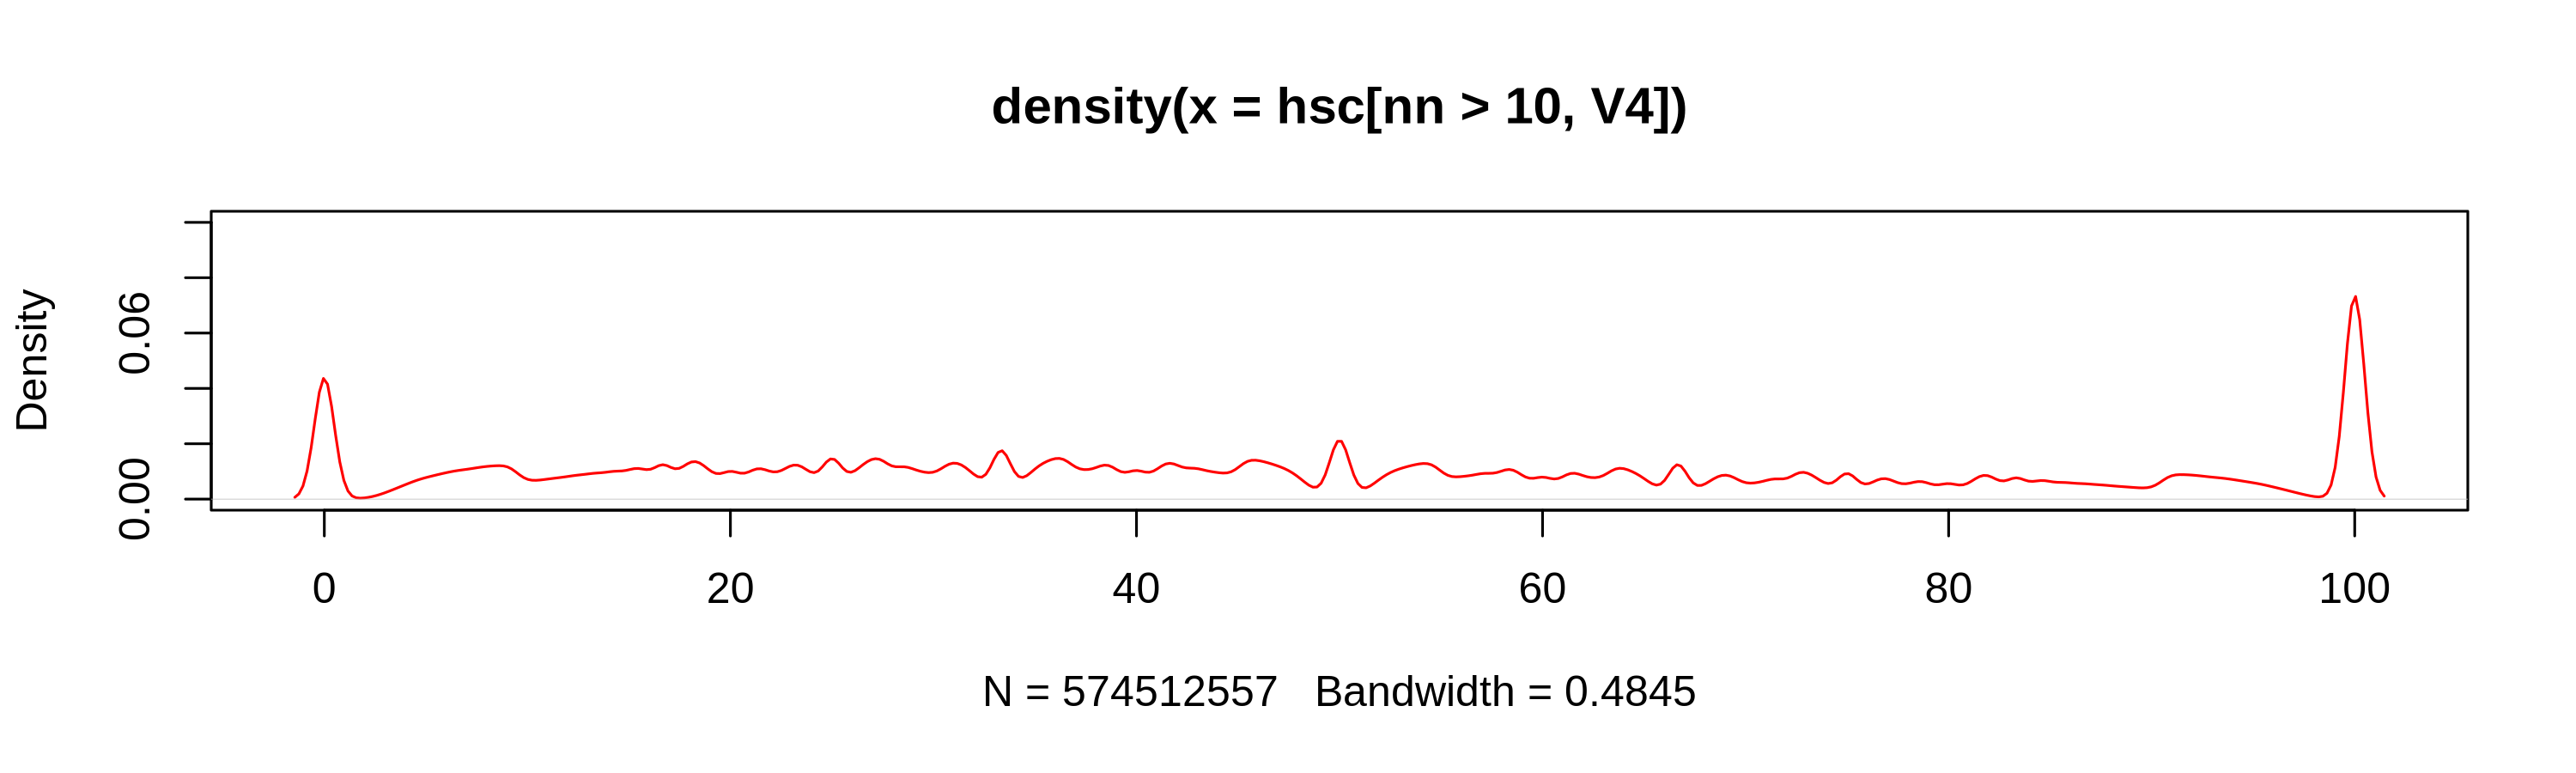

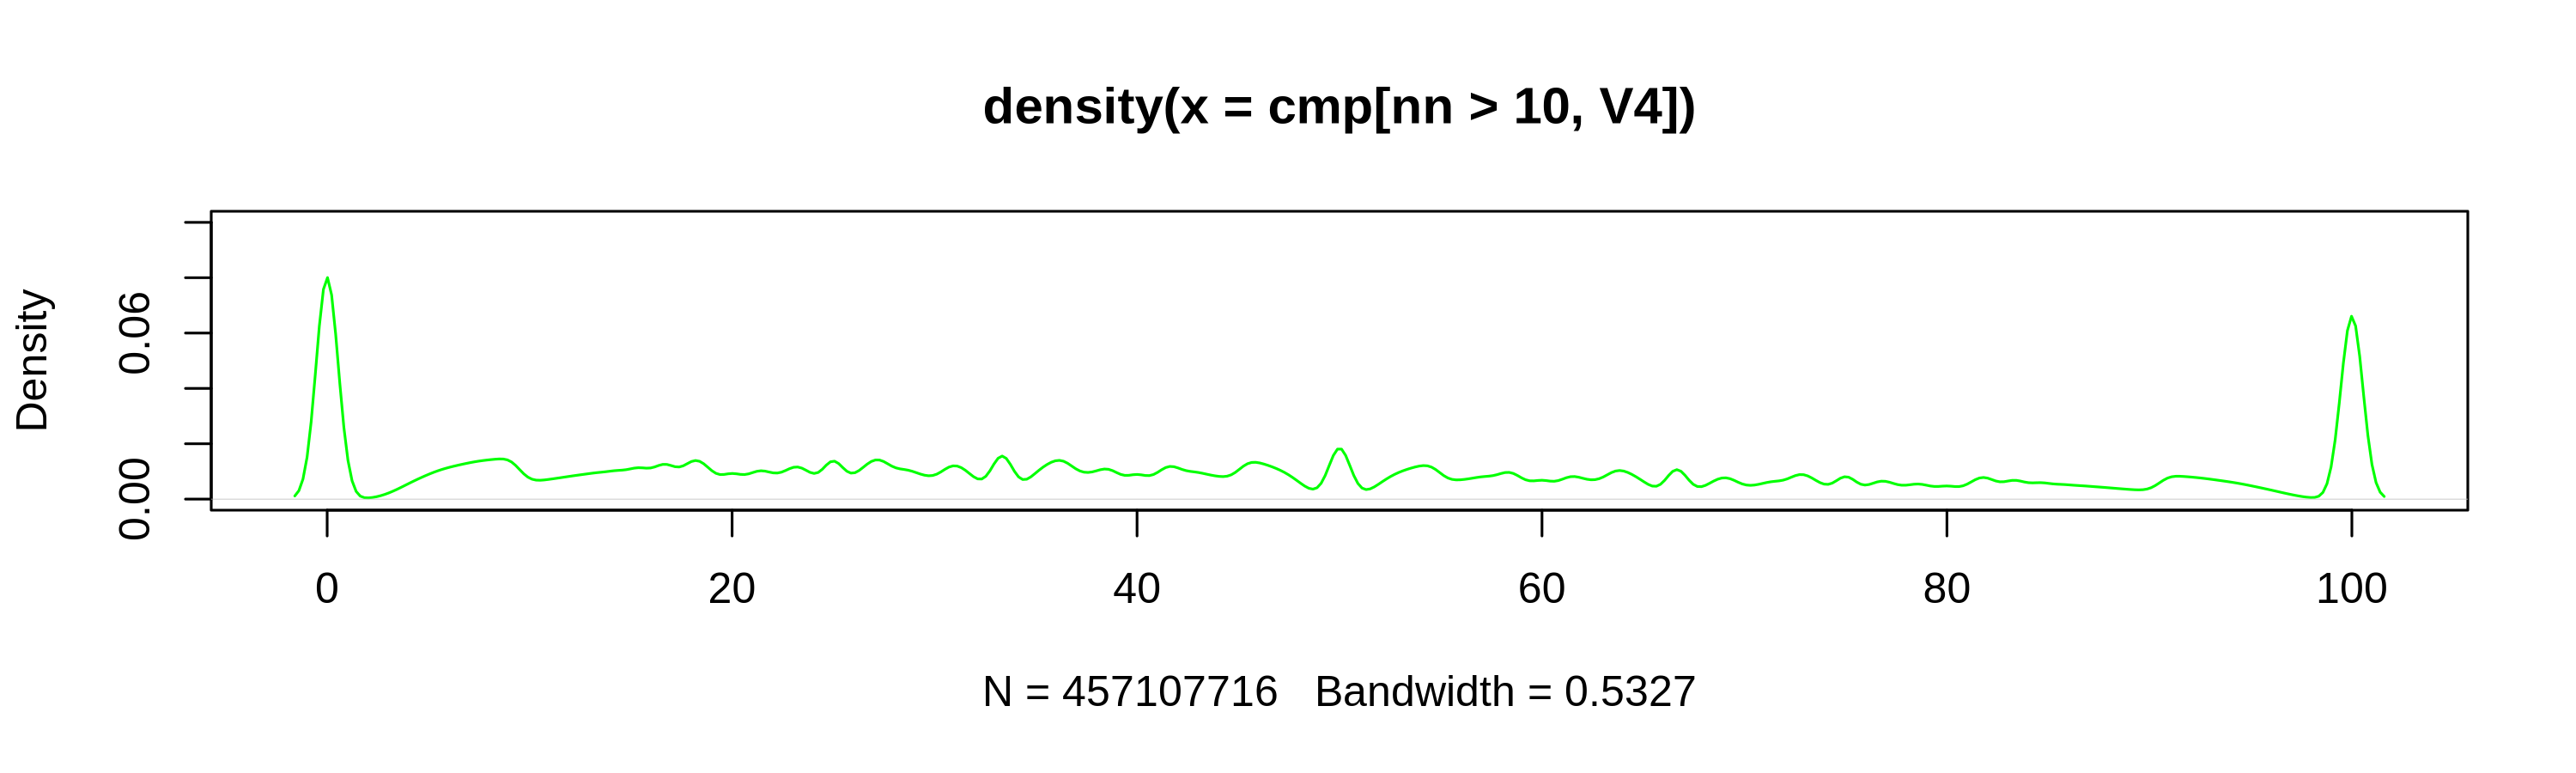

In [193]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 300)
plot(hsc_density, ylim = c(0, .15), col = 'red')
plot(cmp_density, ylim = c(0, .15), col = 'green')
plot(gmp_density, ylim = c(0, .15), col = 'blue')

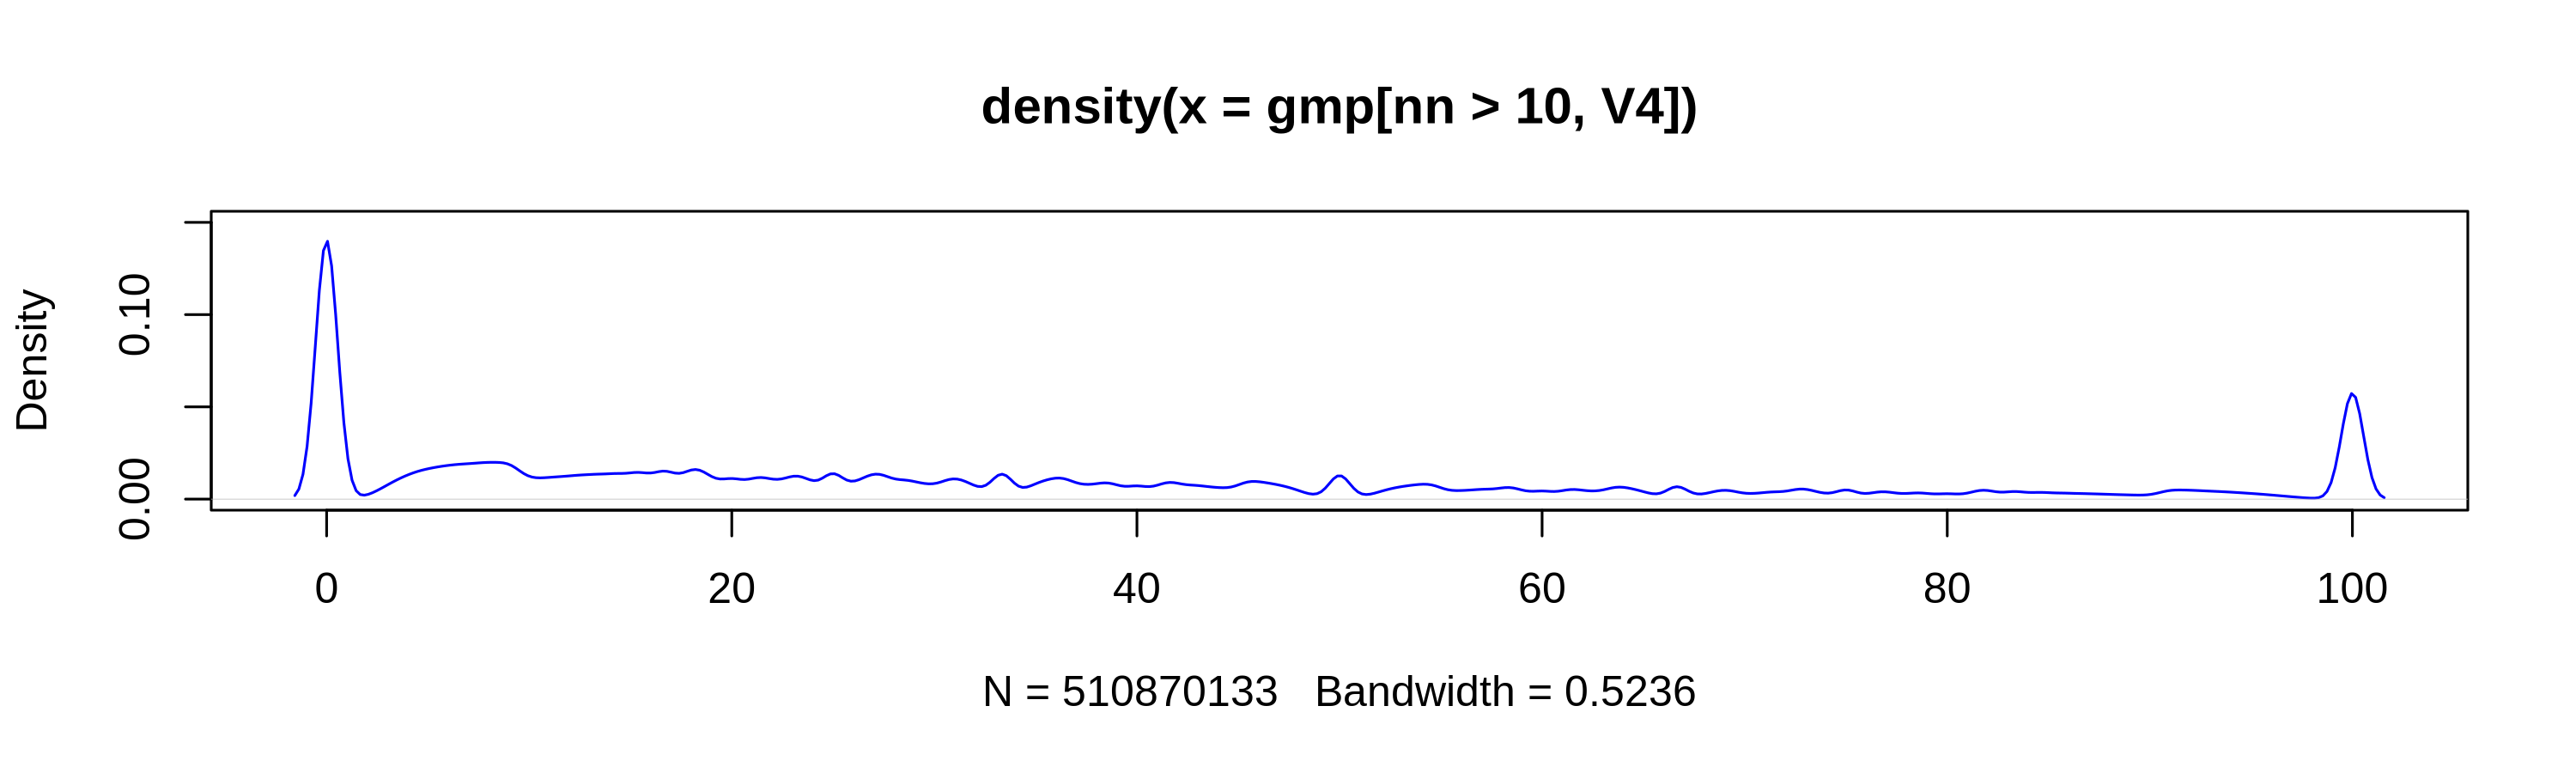

In [204]:
fname = '~/WenhuoHu/collab_Farhan/plot/a.pdf'
pdf(file = fname, width = 3, height = 3)
plot(hsc_density, ylim = c(0, .15), col = 'red')
plot(cmp_density, ylim = c(0, .15), col = 'green')
plot(gmp_density, ylim = c(0, .15), col = 'blue')
dev.off()

png 
  2

# plot IFNGR1 methylation 

In [15]:
library(DBI)
library(Gviz)
library(rtracklayer)
library(Rsamtools)


In [134]:
ii_chr = 'chr6'
ii_start = 138300659
ii_end = 138432712
gr_string = paste0(ii_chr, ':', ii_start, '-', ii_end)
gr_string


[1] "chr6:138300659-138432712"

In [154]:
dsn_meth_ctype[cell_type == 'HSC', ctype_cov_sorted_compressed_file]
dsn_meth_ctype[cell_type == 'CMP', ctype_cov_sorted_compressed_file]

[1] "/home/whu78/WenhuoHu/TE/meth/HSC/HSC_bismark_cov_sorted_compressed_bed.gz"

In [13]:
dsn_meth_ctype[, meth_ex_file := paste0(ctype_dir, '_ex.bed') ]
dsn_meth_ctype[, ex_cmd := paste0('tabix ', ctype_cov_sorted_compressed_file) ]
dsn_meth_ctype[, ex_cmd := paste0(ex_cmd, ' ', gr_string)] 
dsn_meth_ctype[, ex_cmd := paste0(ex_cmd, ' > ', meth_ex_file)] 

write(dsn_meth_ctype$ex_cmd, file = 'run_ex.sh') 


In [27]:
res = as.data.table(dbFetch(dbSendQuery(con, "SELECT * FROM t2t WHERE gene_id = 'IFNGR1' " )))
setnames(res, 'tx_id', 'transcript')
setnames(res, 'gene_id', 'gene')
res[, exon := paste0(transcript, '.', exon_nn ) ]
res[, symbol := gene ]
res[, feat := feature ]
res[feat == 'CDS', feature := 'CDS' ]
res[feat == '5UTR', feature := 'utr5' ]
res[feat == '3UTR', feature := 'utr3' ]
res = res[feature %in% c('CDS', 'utr5', 'utr3'), ]
gene = GeneRegionTrack(res, name = 'IFNGR1', transcriptAnnotation = 'transcript') 


In [ ]:
track1 <- DataTrack(data = data1, from = "38565900" , to = "75505200", chromosome = Chrom$chr1, name = "DMRs")


In [22]:
setkey(dsn_meth_ctype, 'cell_type')

In [142]:
col_names = c("chromosome", "start", "end", "value", "Methylation_Percentage", "Unmethylated_Count")
data = fread(dsn_meth_ctype['HSC', meth_ex_file], col.names = col_names) 
hsc_track <- DataTrack( range = GRanges( seqnames = data$chromosome, ranges = IRanges(start = data$start, end = data$end) ),
  data = data$value, genome = "t2t", name = "HSC meth", ylim = c(0, 100) )
data = fread(dsn_meth_ctype['CMP', meth_ex_file], col.names = col_names) 
cmp_track <- DataTrack( range = GRanges( seqnames = data$chromosome, ranges = IRanges(start = data$start, end = data$end) ),
  data = data$value, genome = "t2t", name = "CMP meth", ylim = c(0, 100) )
data = fread(dsn_meth_ctype['GMP', meth_ex_file], col.names = col_names) 
gmp_track <- DataTrack( range = GRanges( seqnames = data$chromosome, ranges = IRanges(start = data$start, end = data$end) ),
  data = data$value, genome = "t2t", name = "GMP meth", ylim = c(0, 100) )


In [28]:
ax <- GenomeAxisTrack(name = 'chr6')


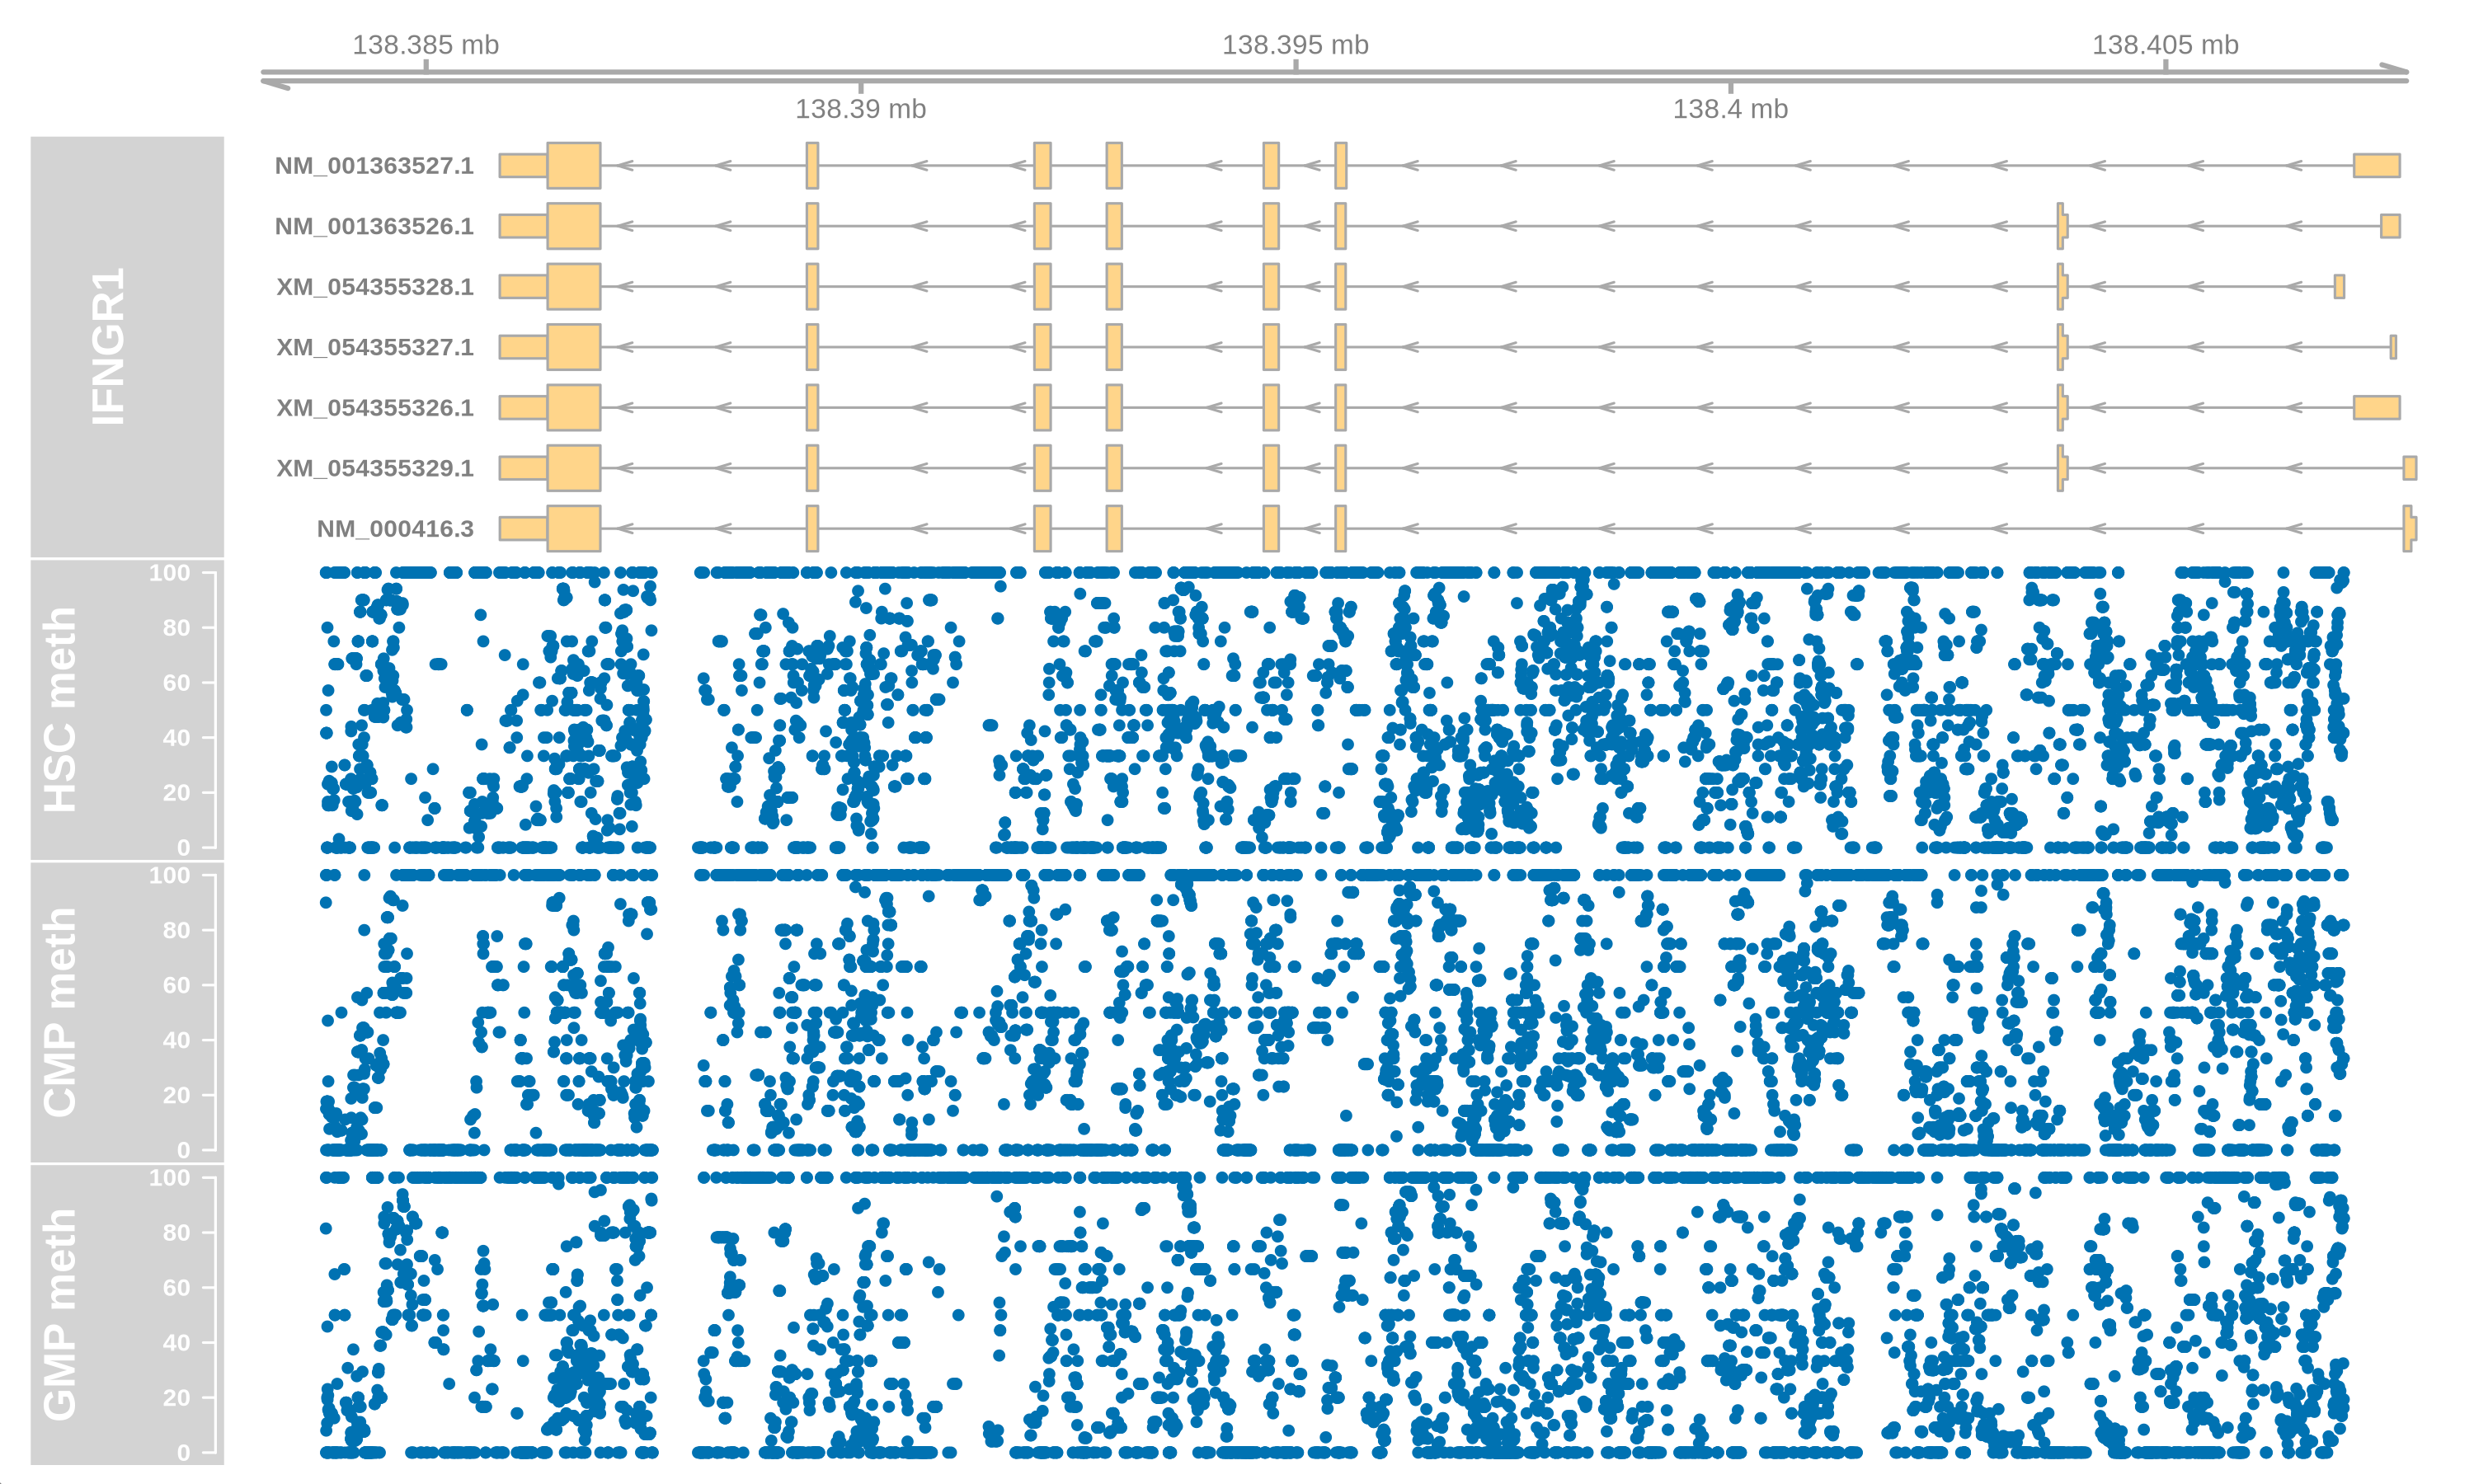

In [143]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 300)

#plotTracks( list(ax, gene, hsc_bwTrack), chromosome = 'chr6', from = 138385847, to = 138407049, extend.right = 1000, extend.left = 1000)
plotTracks( list(ax, gene, hsc_track, cmp_track, gmp_track), chromosome = 'chr6', from = 138383847, to = 138407049, extend.right = 1000, extend.left = 1000)


In [59]:
ann = readRDS(file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/deg_teloccal_cmp_anno_nov7.rds')

In [61]:
res_te = as.data.table(dbFetch(dbSendQuery(con, "SELECT * FROM t2t_te WHERE chromosome = 'chr6' and start > 138385847 and end < 138407878")) )
gene_te = GeneRegionTrack(res_te, collapse_rows = T, name = 'TEs')


Warning message:
"Closing open result set, pending rows"


In [68]:
cpg = read_xlsx('~/WenhuoHu/Supplementary Table S4.xlsx', sheet = 3, skip = 2) 
cpg = as.data.table(cpg)
setnames(cpg, 1, 'chr') 
setnames(cpg, 2, 'start') 
setnames(cpg, 3, 'end') 
setnames(cpg, 4, 'nn') 
cpg[, id := paste0('cgi_', nn) ]

saveRDS(cpg, file = 'cpg_t2t.rds')

In [69]:
head(cpg)

chr,start,end,nn,CGI length,GC content,O/E ratio,CGcount,CpG density,id
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr10,5890,5910,1,21,0.9048,1.400,6,0.2857143,cgi_1
chr10,5917,5939,2,23,0.9130,1.464,7,0.3043478,cgi_2
chr10,5946,5968,3,23,0.9130,1.464,7,0.3043478,cgi_3
chr10,5975,5997,4,23,0.9130,1.464,7,0.3043478,cgi_4
chr10,6004,6026,5,23,0.9130,1.464,7,0.3043478,cgi_5
chr10,6033,6055,6,23,0.9130,1.464,7,0.3043478,cgi_6


In [135]:
ex = 50000

cpg_sel = cpg[chr == ii_chr & start > ii_start - ex & end < ii_end + ex, ]
cpg_islands <- GRanges(seqnames = cpg_sel$chr,  ranges = IRanges(start = cpg_sel$start, end = cpg_sel$end),  names = cpg_sel$id)
cpg_islands
cpg_track <- AnnotationTrack(cpg_islands,  name = "CpG Islands",  genome = "t2t",  featureAnnotation = "names", chromosome = ii_chr) 
#chr6:138407436-138408034
#138432712

GRanges object with 0 ranges and 1 metadata column:
   seqnames    ranges strand |       names
      <Rle> <IRanges>  <Rle> | <character>
  -------
  seqinfo: no sequences

In [78]:
library(methylkit)

ERROR: Error in library(methylkit): there is no package called 'methylkit'


In [138]:
res_te[start < 138397000 & end > 138397000, ]

chromosome,V2,feature,start,end,V6,strand,V8,V9,gene_id,tx_id,family_id,class_id
<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr6,UCSC_rmsk,exon,138396301,138397857,11696,+,.,"gene_id ""THE1A""; transcript_id ""THE1A_dup1758""; family_id ""ERVL-MaLR""; class_id ""LTR"";",THE1A,THE1A_dup1758,ERVL-MaLR,LTR


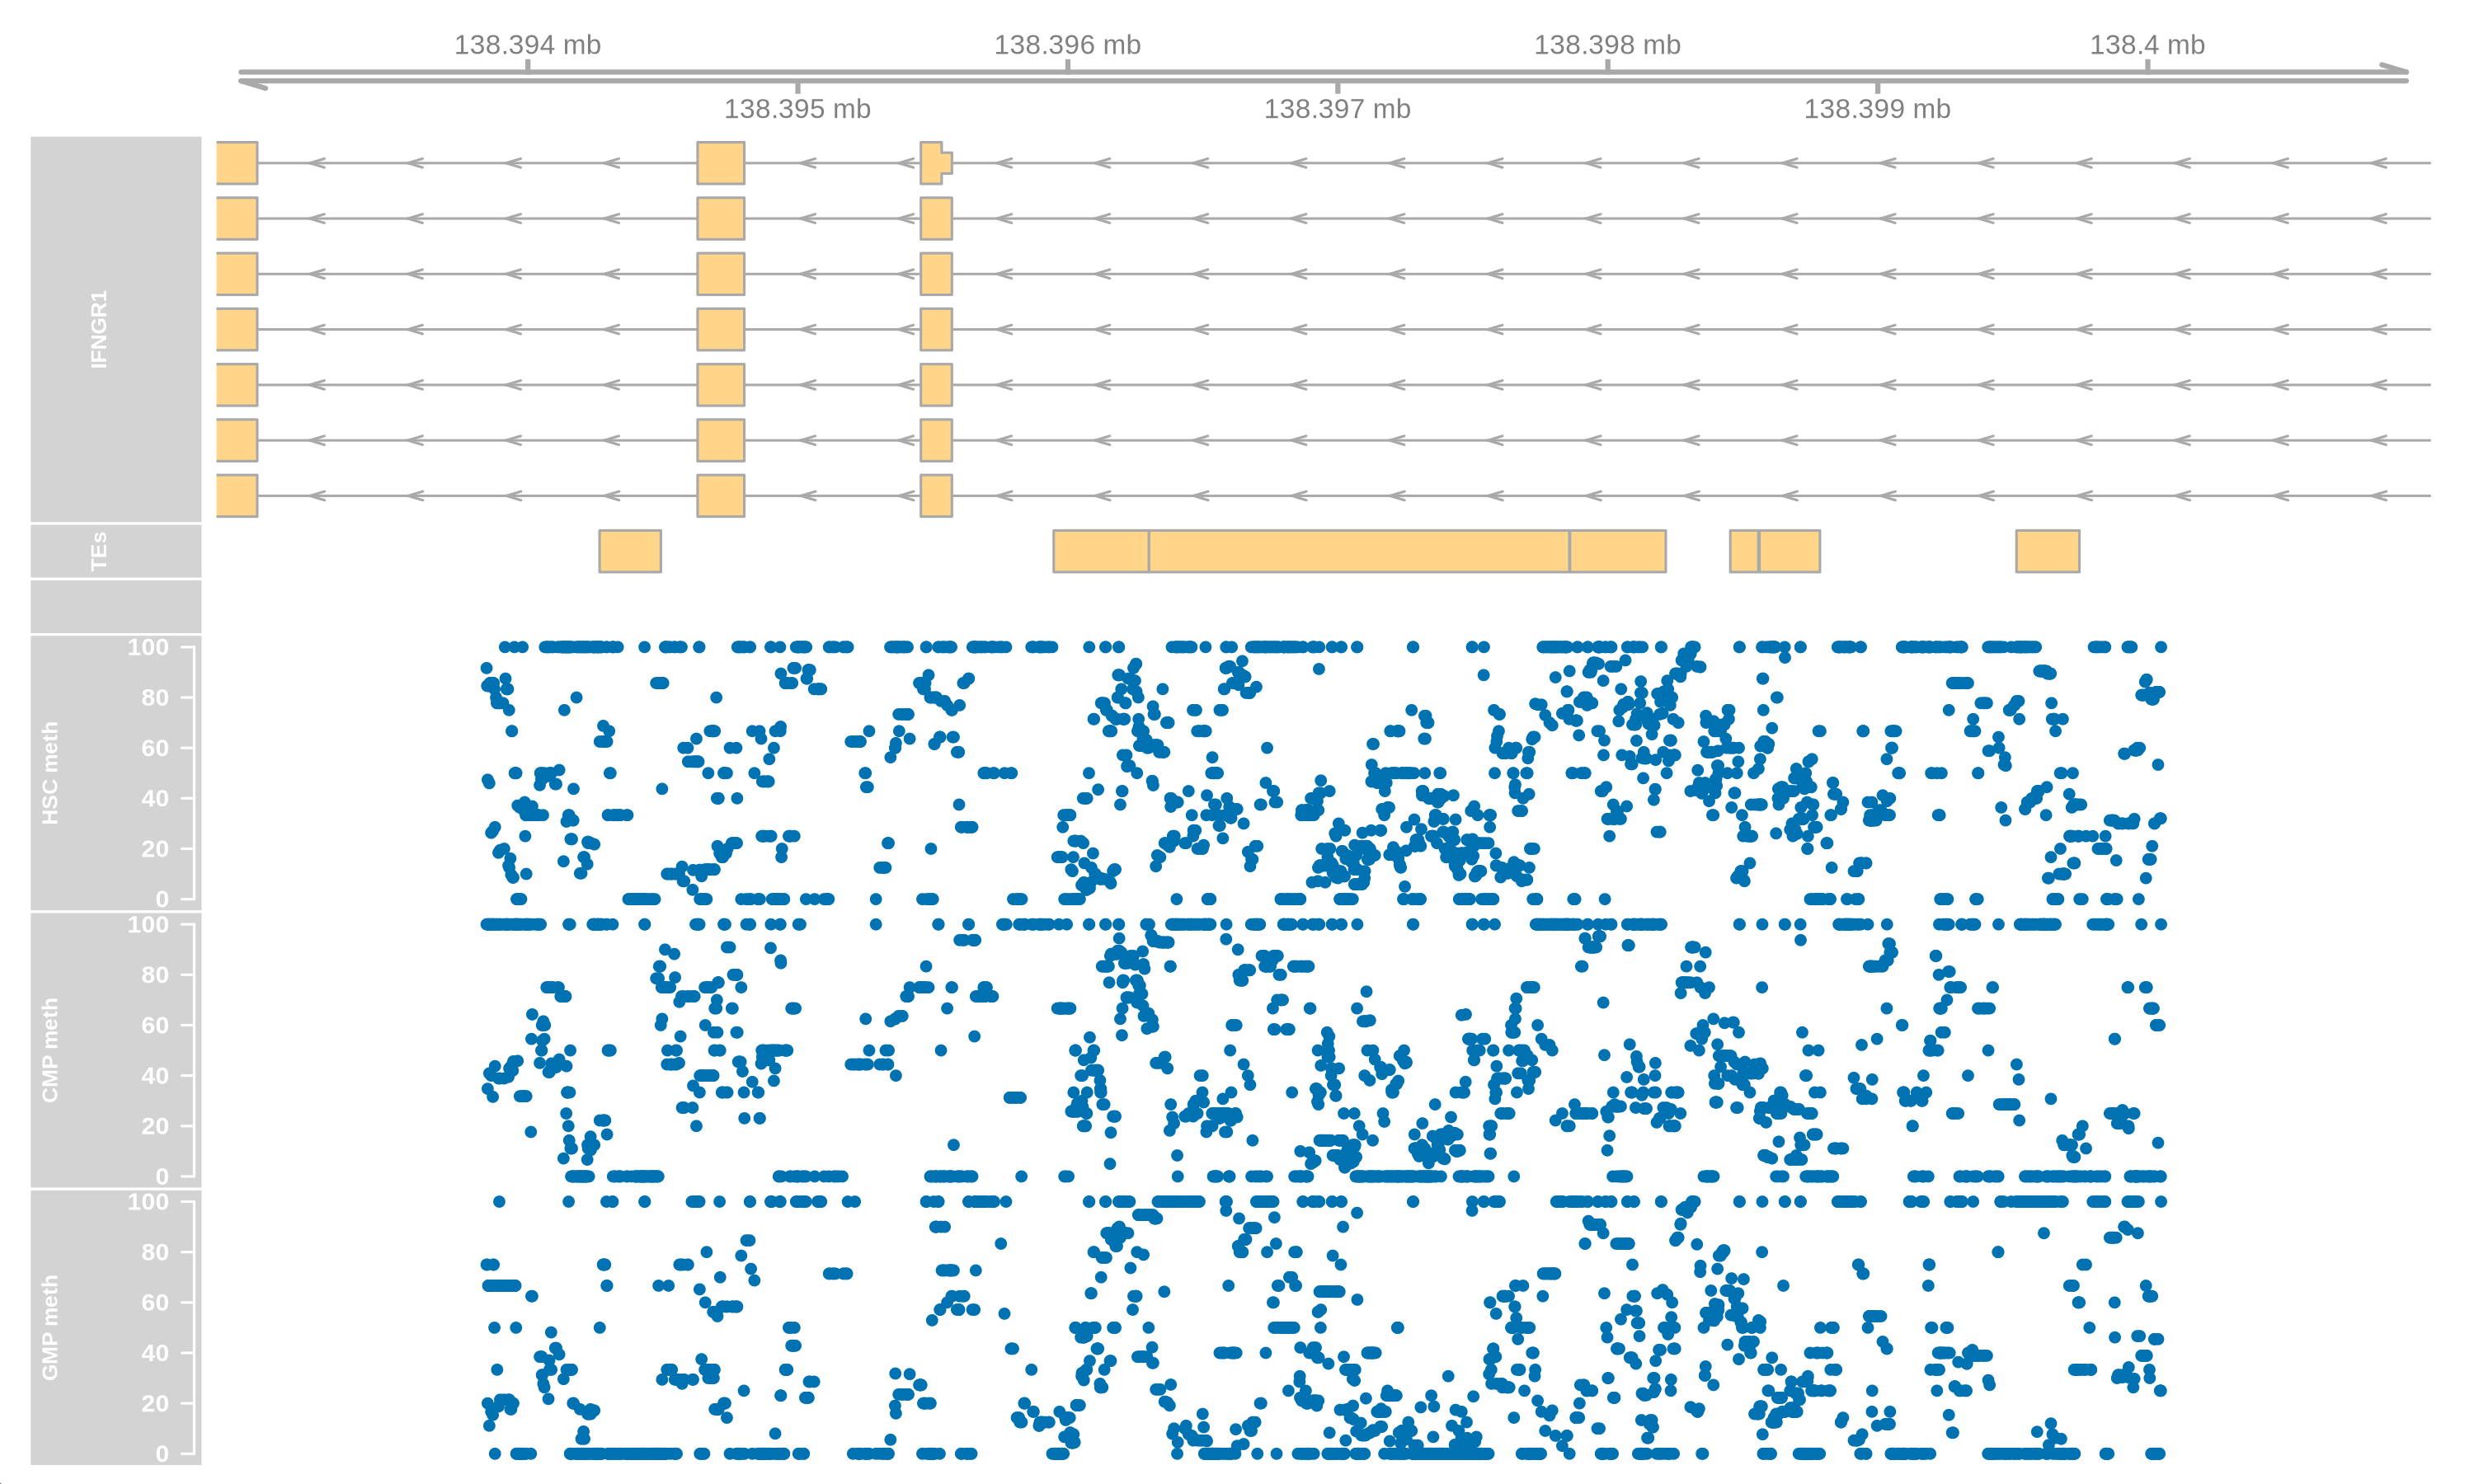

In [144]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 300)

#plotTracks( list(ax, gene, hsc_bwTrack), chromosome = 'chr6', from = 138385847, to = 138407049, extend.right = 1000, extend.left = 1000)
plotTracks( list(ax, gene, gene_te, cpg_track, hsc_track, cmp_track, gmp_track), chromosome = 'chr6', from = 138393847, to = 138400049, extend.right = 1000, extend.left = 1000)


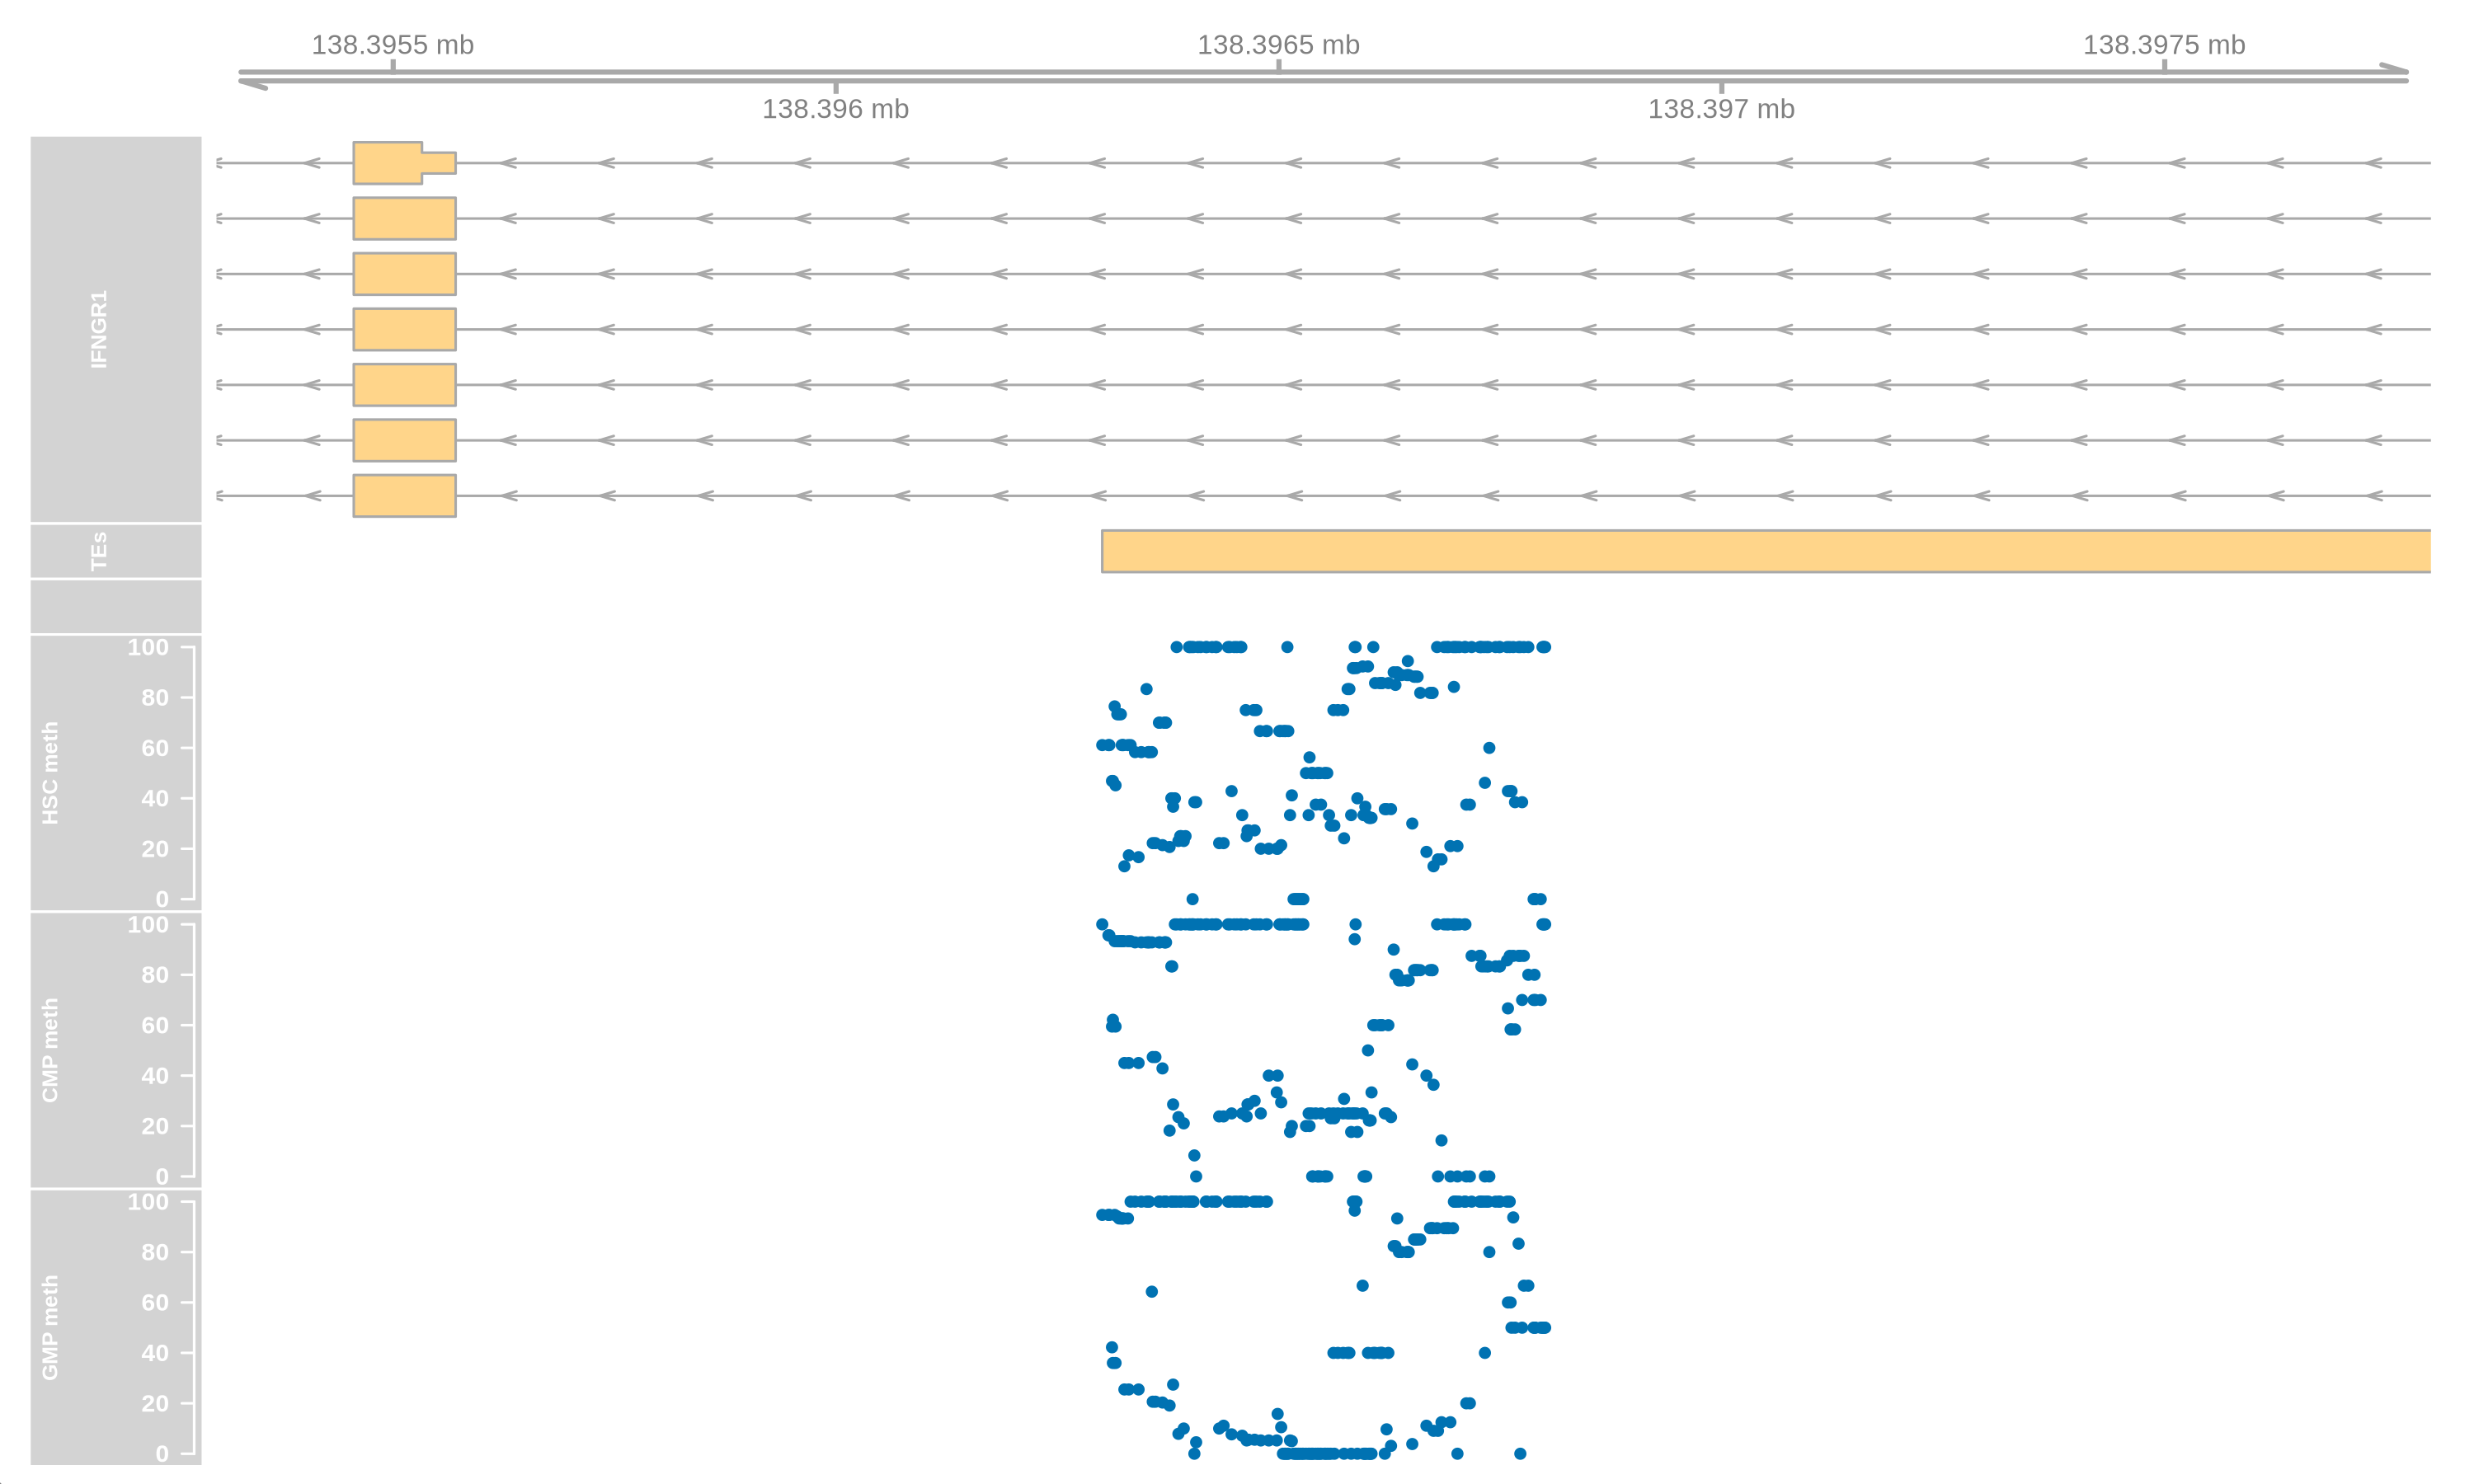

In [145]:
options(repr.plot.width = 10, repr.plot.height = 6, repr.plot.res = 300)

#plotTracks( list(ax, gene, hsc_bwTrack), chromosome = 'chr6', from = 138385847, to = 138407049, extend.right = 1000, extend.left = 1000)
plotTracks( list(ax, gene, gene_te, cpg_track, hsc_track, cmp_track, gmp_track), chromosome = 'chr6', from = 138396301, to = 138396301 + 500, extend.right = 1000, extend.left = 1000)


In [140]:
138396301	-138397857

[1] -1556

In [152]:
ii_chr = 'chr6'
ii_start = 138397000
ii_end = 138398000
#chr6:138407436-138408034
ii_start = 138407436
ii_end = 138408034
ii_start = 138396301
ii_end = 138396301 + 300
# 138396301	138397857

col_names = c("chromosome", "start", "end", "value", "Methylation_Percentage", "Unmethylated_Count")
data1 = fread(dsn_meth_ctype['HSC', meth_ex_file], col.names = col_names) 
data2 = fread(dsn_meth_ctype['CMP', meth_ex_file], col.names = col_names) 
data3 = fread(dsn_meth_ctype['GMP', meth_ex_file], col.names = col_names) 
data1 = data1[start > ii_start & end < ii_end, ]
data2 = data2[start > ii_start & end < ii_end, ]
data3 = data3[start > ii_start & end < ii_end, ]
tmp = list(data1, data2, data3) 
names(tmp) = c('HSC', 'CMP', 'GMP')
tmp = rbindlist(tmp, idcol = T) 
tmp[, mm := median(value), by = '.id' ]
tmp = tmp[!duplicated(.id), ]

head(tmp) 


.id,chromosome,start,end,value,Methylation_Percentage,Unmethylated_Count,mm
<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<dbl>
HSC,chr6,138396308,138396308,61.11111,11,7,50.00000
CMP,chr6,138396308,138396308,95.65217,22,1,92.85714
GMP,chr6,138396308,138396308,94.73684,18,1,36.00000


In [92]:
f1 = dsn_meth_ctype_donor[cell_type == 'HSC',.(cell_type, ctype_donor, ctype_donor_cov_file)]
f2 = dsn_meth_ctype_donor[cell_type == 'CMP',.(cell_type, ctype_donor, ctype_donor_cov_file)]
ff = rbind(f1, f2)
ff[, tx := 0]
ff[cell_type == 'HSC', tx := 1]
ff

cell_type,ctype_donor,ctype_donor_cov_file,tx
<chr>,<chr>,<chr>,<dbl>
HSC,HSC_D10,/home/whu78/WenhuoHu/TE/meth/HSC_D10/HSC_D10_bismark_cov.gz,1
HSC,HSC_D4,/home/whu78/WenhuoHu/TE/meth/HSC_D4/HSC_D4_bismark_cov.gz,1
HSC,HSC_D5,/home/whu78/WenhuoHu/TE/meth/HSC_D5/HSC_D5_bismark_cov.gz,1
HSC,HSC_D6,/home/whu78/WenhuoHu/TE/meth/HSC_D6/HSC_D6_bismark_cov.gz,1
HSC,HSC_D7,/home/whu78/WenhuoHu/TE/meth/HSC_D7/HSC_D7_bismark_cov.gz,1
HSC,HSC_D9,/home/whu78/WenhuoHu/TE/meth/HSC_D9/HSC_D9_bismark_cov.gz,1
CMP,CMP_D2,/home/whu78/WenhuoHu/TE/meth/CMP_D2/CMP_D2_bismark_cov.gz,0
CMP,CMP_D1,/home/whu78/WenhuoHu/TE/meth/CMP_D1/CMP_D1_bismark_cov.gz,0
CMP,CMP_D3,/home/whu78/WenhuoHu/TE/meth/CMP_D3/CMP_D3_bismark_cov.gz,0


In [117]:
read.bismark(files = ff$ctype_donor_cov_file[1])

ERROR: Error in read.bismark(files = ff$ctype_donor_cov_file[1]): unused argument (files = ff$ctype_donor_cov_file[1])


In [96]:
as.list(ff$ctype_donor_cov_file)

[[1]]
[1] "/home/whu78/WenhuoHu/TE/meth/HSC_D10/HSC_D10_bismark_cov.gz"

[[2]]
[1] "/home/whu78/WenhuoHu/TE/meth/HSC_D4/HSC_D4_bismark_cov.gz"

[[3]]
[1] "/home/whu78/WenhuoHu/TE/meth/HSC_D5/HSC_D5_bismark_cov.gz"

[[4]]
[1] "/home/whu78/WenhuoHu/TE/meth/HSC_D6/HSC_D6_bismark_cov.gz"

[[5]]
[1] "/home/whu78/WenhuoHu/TE/meth/HSC_D7/HSC_D7_bismark_cov.gz"

[[6]]
[1] "/home/whu78/WenhuoHu/TE/meth/HSC_D9/HSC_D9_bismark_cov.gz"

[[7]]
[1] "/home/whu78/WenhuoHu/TE/meth/CMP_D2/CMP_D2_bismark_cov.gz"

[[8]]
[1] "/home/whu78/WenhuoHu/TE/meth/CMP_D1/CMP_D1_bismark_cov.gz"

[[9]]
[1] "/home/whu78/WenhuoHu/TE/meth/CMP_D3/CMP_D3_bismark_cov.gz"

In [104]:
length(as.list(ff$ctype_donor_cov_file)) 

[1] 9

In [115]:
?read.bismark

methylKit-defunct {methylKit},R Documentation


In [114]:
methRead

new("standardGeneric", .Data = function (location, sample.id, 
    assembly, dbtype = NA, pipeline = "amp", header = TRUE, skip = 0, 
    sep = "\t", context = "CpG", resolution = "base", treatment = NA, 
    dbdir = getwd(), mincov = 10) 
standardGeneric("methRead"), generic = "methRead", package = "methylKit", 
    group = list(), valueClass = character(0), signature = c("location", 
    "sample.id", "assembly", "dbtype", "pipeline", "header", 
    "skip", "sep", "context", "resolution", "treatment", "dbdir", 
    "mincov"), default = NULL, skeleton = (function (location, 
        sample.id, assembly, dbtype = NA, pipeline = "amp", header = TRUE, 
        skip = 0, sep = "\t", context = "CpG", resolution = "base", 
        treatment = NA, dbdir = getwd(), mincov = 10) 
    stop(gettextf("invalid call in method dispatch to '%s' (no default method)", 
        "methRead"), domain = NA))(location, sample.id, assembly, 
        dbtype, pipeline, header, skip, sep, context, resolution, 
        treatment, dbdir, mincov))
<bytecode: 0x5555cc2cf970>
<environment: 0x5555cc301a60>
attr(,"generic")
[1] "methRead"
attr(,"generic")attr(,"package")
[1] "methylKit"
attr(,"package")
[1] "methylKit"
attr(,"group")
list()
attr(,"valueClass")
character(0)
attr(,"signature")
 [1] "location"   "sample.id"  "assembly"   "dbtype"     "pipeline"  
 [6] "header"     "skip"       "sep"        "context"    "resolution"
[11] "treatment"  "dbdir"      "mincov"    
attr(,"default")
`\001NULL\001`
attr(,"skeleton")
(function (location, sample.id, assembly, dbtype = NA, pipeline = "amp", 
    header = TRUE, skip = 0, sep = "\t", context = "CpG", resolution = "base", 
    treatment = NA, dbdir = getwd(), mincov = 10) 
stop(gettextf("invalid call in method dispatch to '%s' (no default method)", 
    "methRead"), domain = NA))(location, sample.id, assembly, 
    dbtype, pipeline, header, skip, sep, context, resolution, 
    treatment, dbdir, mincov)
attr(,"class")
[1] "standardGeneric"
attr(,"class")attr(,"package")
[1] "methods"

In [113]:
methRead(ff$ctype_donor_cov_file[1], header = T, pipeline = 'bismark')

Received single location.



ERROR: Error in .local(location, sample.id, assembly, dbtype, pipeline, header, : Cannot directly load uncompressed file:
 /home/whu78/WenhuoHu/TE/meth/HSC_D10/HSC_D10_bismark_cov.gz 

Please provide sample.id and assembly.


In [111]:
library(methylKit)

# read the files to a methylRawList object: myobj
myobj=methRead(as.list(ff$ctype_donor_cov_file), header = F, sample.id=list(ff$ctype_donor), assembly="t2t", treatment= ff$tx, context="CpG", mincov = 10, pipeline = 'bismark' )
#myobj=methRead(as.list(ff$ctype_donor_cov_file), sample.id=list(ff$ctype_donor), assembly="t2t", treatment= ff$tx, context="CpG", mincov = 10, pipeline = 'bismark' )


Received list of locations.



ERROR: Error in methRead(as.list(ff$ctype_donor_cov_file), header = F, sample.id = list(ff$ctype_donor), : length of 'location'  and 'name' should be same



In [108]:
?methRead

methRead {methylKit},R Documentation
location,"file location(s), either a list of locations (each a character string) or one location string"
sample.id,sample.id(s)
assembly,"a string that defines the genome assembly such as hg18, mm9. this is just a string for book keeping. It can be any string. Although, when using multiple files from the same assembly, this string should be consistent in each object."
dbtype,"type of the flat file database, currently only option other than NA is ""tabix"". When ""tabix"" is given the objects are stored in tabix files, which are compressed and indexed. The default value is NA, in which case the objects are stored in memory."
pipeline,"name of the alignment pipeline, it can be either ""amp"", ""bismark"",""bismarkCoverage"", ""bismarkCytosineReport"" or a list (default:'amp'). The methylation text files generated from other pipelines can be read as generic methylation text files by supplying a named list argument as ""pipeline"" argument. The named list should containt column numbers which denotes which column of the text file corresponds to values and genomic location of the methylation events. See Details for more on possible values for this argument."
header,if the input file has a header or not (default: TRUE)
skip,number of lines to skip when reading. Can be set to 1 for bed files with track line (default: 0)
sep,"seperator between fields, same as read.table argument (default: ""\t"")"
context,"methylation context string, ex: CpG,CHG,CHH, etc. (default:CpG)"
resolution,designates whether methylation information is base-pair resolution or regional resolution. allowed values 'base' or 'region'. Default 'base'


# coverage2cytosine


In [309]:
dir.create('/home/whu78/WenhuoHu/TE/meth/')

In [25]:
#inv = dsn[, {dir.create(ctype_donor_dir)}, by = 1:nrow(dsn)]


In [313]:
dsn[, ctype_donor_cpg_ot_file := paste0(ctype_donor_dir, 'CpG_OT_', ctype_donor, '.txt.gz') ]
dsn[, ctype_donor_cpg_ob_file := paste0(ctype_donor_dir, 'CpG_OB_', ctype_donor, '.txt.gz') ]

dsn[, ctype_donor_chg_ot_file := paste0(ctype_donor_dir, 'CHG_OT_', ctype_donor, '.txt.gz') ]
dsn[, ctype_donor_chg_ob_file := paste0(ctype_donor_dir, 'CHG_OB_', ctype_donor, '.txt.gz') ]

dsn[, ctype_donor_chh_ot_file := paste0(ctype_donor_dir, 'CHH_OT_', ctype_donor, '.txt.gz') ]
dsn[, ctype_donor_chh_ob_file := paste0(ctype_donor_dir, 'CHH_OB_', ctype_donor, '.txt.gz') ]


In [319]:
dsn[, cov_cpg_ob_jobname := paste0('cov_cpg_ob_', ctype_donor, '_', proj_meth)]
dsn[, cov_cpg_ob_oo := paste0(ctype_donor_dir, cov_cpg_ob_jobname, '_out')]
dsn[, cov_cpg_ob_eo := paste0(ctype_donor_dir, cov_cpg_ob_jobname, '_err')]

dsn[, cov_cpg_ob_cmd := paste0('bsub -J ', cov_cpg_ob_jobname, ' -o ', cov_cpg_ob_oo, ' -e ', cov_cpg_ob_eo)]
dsn[, cov_cpg_ob_cmd := paste0(cov_cpg_ob_cmd, ' -n 5 -R "span[hosts=1]" -R "rusage[mem=5GB]" -W 240:00 ')]
dsn[, cov_cpg_ob_cmd := paste0(cov_cpg_ob_cmd, ' " singularity exec --bind ', ctype_donor_dir, ' --bind ', gnome$bismark_index, ' ', sif$bismark, ' ')]
dsn[, cov_cpg_ob_cmd := paste0(cov_cpg_ob_cmd, 'coverage2cytosine ')] 
dsn[, cov_cpg_ob_cmd := paste0(cov_cpg_ob_cmd, '--gzip -o ', basename(ctype_donor_cpg_ob_file), ' --dir ', ctype_donor_dir, ' ') ]
dsn[, cov_cpg_ob_cmd := paste0(cov_cpg_ob_cmd, '--genome_folder ', gnome$bismark_index, ' ', paste(cpg_ob_file, collapse = ' '), ' "'), by = 'ctype_donor']

write(dsn[!duplicated(ctype_donor), cov_cpg_ob_cmd], file = paste0('run_cov_cpg_ob.sh'))



In [33]:
dsn[1, ctype_donor_dir]

[1] "/home/whu78/WenhuoHu/TE/meth/MLP3_D2/"

In [318]:
dim(dsn_meth)

[1] 59 52

In [317]:
getwd()

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan"

In [ ]:
# merge bam file
coverage2cytosine --genome_folder <path_to_genome> -o output_file coverage_file


# export/import methylation

In [ ]:
colnames(dsn)

In [28]:
save(dsn, dsn_meth_ctype_donor, dsn_meth_ctype, file = 'dsn_methylation.rdata')


In [32]:
load('~/dsn_methylation.rdata')


In [33]:
save(dsn, dsn_meth_ctype, dsn_meth_ctype_donor, file = 'dsn.rdata')

# backup code

In [279]:
dim(dsn[file.exists(dsn$chg_file), ])

[1] 639  37

In [7]:
count_df_te     = read.table(file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/count_df_te.tsv', sep = '\t')
count_df_coding = read.table(file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/count_df_coding.tsv', sep = '\t')


In [15]:
mtx_dxrel = rbind(count_df_coding, count_df_te) 


In [10]:
mtx_hspc = readRDS('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/mtx_all_df.rds')


In [24]:
all(rownames(mtx_dxrel) == rownames(mtx_hspc))


[1] TRUE

In [25]:
mtx = cbind(mtx_hspc, mtx_dxrel)


In [39]:
deg_telocal_MEPCMP = fread(file = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/deg_telocal_MEPCMP_15Jul.tsv')
head(deg_telocal_MEPCMP)


.id,rn,logFC,logCPM,PValue,FDR,batch,target,class_id,family_id,gene_id,tx_id
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
deg_telocal_MEP_EB,MSTD_dup4711:MSTD:ERVL-MaLR:LTR,-15.14818,10.847784,2.234428e-10,6.451911e-06,MEP,EB,LTR,ERVL-MaLR,MSTD,MSTD_dup4711
deg_telocal_MEP_EB,L1ME3G_dup281:L1ME3G:L1:LINE,-13.22592,8.928775,2.035238e-08,1.122423e-04,MEP,EB,LINE,L1,L1ME3G,L1ME3G_dup281
deg_telocal_MEP_EB,L1MC5a_dup9954:L1MC5a:L1:LINE,-13.30574,9.008395,2.299462e-08,1.122423e-04,MEP,EB,LINE,L1,L1MC5a,L1MC5a_dup9954
deg_telocal_MEP_EB,LTR2_dup109:Harlequin-int:ERV1:LTR,-14.01686,9.717875,1.036616e-07,1.122423e-04,MEP,EB,LTR,ERV1,Harlequin-int,LTR2_dup109
deg_telocal_MEP_EB,L1PA10_dup901:L1PA10:L1:LINE,-12.41123,8.117376,1.454230e-07,1.122423e-04,MEP,EB,LINE,L1,L1PA10,L1PA10_dup901
deg_telocal_MEP_EB,L1MA4A_dup1872:L1MA4A:L1:LINE,-11.91200,7.621480,3.271400e-07,1.122423e-04,MEP,EB,LINE,L1,L1MA4A,L1MA4A_dup1872


In [35]:
deg_MEPCMP = fread('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/data/deg_MEPCMP15Jul.tsv') 
head(deg_MEPCMP)


.id,rn,logFC,logCPM,PValue,FDR,batch,target,class_id,family_id,gene_id
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
deg_MEP_EB,Ricksha_c:MULE-MuDR:DNA,1.794502,9.671313,3.537422e-15,3.855790e-12,MEP,EB,DNA,MULE-MuDR,Ricksha_c
deg_MEP_EB,MER4-int:ERV1:LTR,-1.552194,10.178204,8.196779e-12,4.467245e-09,MEP,EB,LTR,ERV1,MER4-int
deg_MEP_EB,HERV1_I:ERV1:LTR,4.016606,8.909953,1.601935e-11,5.820362e-09,MEP,EB,LTR,ERV1,HERV1_I
deg_MEP_EB,MER1B:hAT-Charlie:DNA,1.311878,11.324185,1.354780e-10,3.691776e-08,MEP,EB,DNA,hAT-Charlie,MER1B
deg_MEP_EB,MER92C:ERV1:LTR,-6.102215,4.219076,1.113748e-09,2.011836e-07,MEP,EB,LTR,ERV1,MER92C
deg_MEP_EB,MER31-int:ERV1:LTR,-1.827139,9.028825,1.243251e-09,2.011836e-07,MEP,EB,LTR,ERV1,MER31-int


In [21]:
dsn = data.table(rn = c(colnames(mtx_hspc), colnames(mtx_dxrel)))
dsn[, batch := c(rep('HSPC', ncol(mtx_hspc)), rep('dxrel', ncol( mtx_dxrel )))]
dsn[, group := sub('\\d+', '', rn)]
dsn[, group := sub('.*__', '', group)]
head(dsn)
tail(dsn)


rn,batch,group
<chr>,<chr>,<chr>
CLP1,HSPC,CLP
CLP2,HSPC,CLP
CLP3,HSPC,CLP
CMP1,HSPC,CMP
CMP2,HSPC,CMP
CMP3,HSPC,CMP


rn,batch,group
<chr>,<chr>,<chr>
AML_128_Dx,dxrel,Dx
AML_128_rel,dxrel,rel
AML_133_Dx,dxrel,Dx
AML_133_rel,dxrel,rel
AML_139_Dx,dxrel,Dx
AML_139_rel,dxrel,rel


In [42]:
dsn_df = setDF(dsn[, 2:ncol(dsn)], rownames = dsn$rn)

In [22]:
library(sva)

In [29]:
mtx_combat = ComBat_seq(mtx, batch=dsn$batch, group=NULL)


Found 2 batches
Using null model in ComBat-seq.
Adjusting for 0 covariate(s) or covariate level(s)
Estimating dispersions
Fitting the GLM model
Shrinkage off - using GLM estimates for parameters
Adjusting the data


In [31]:
logcpm_mtx = cpm_fun(mtx, dsn) 

In [32]:
head(logcpm_mtx) 


,CLP1,CLP2,CLP3,CMP1,CMP2,CMP3,EB1,EB2,EB3,GMP1,⋯,AML_124_Dx,AML_124_rel,AML_125_Dx,AML_125_rel,AML_128_Dx,AML_128_rel,AML_133_Dx,AML_133_rel,AML_139_Dx,AML_139_rel
A1BG,-1.866523,0.9039367,1.913093,1.902119,3.386882,2.370129,-1.4125155,-2.460849,-2.6446735,-0.1183489,⋯,1.329072,1.3992190,-0.6712793,-1.3100670,1.999921,2.1388997,1.0584466,3.0355154,1.895112,2.1403806
A1BG-AS1,-4.645329,-4.9842853,1.973989,-4.984285,2.543419,2.293537,-0.5942777,-1.053690,-1.3395005,-1.8707111,⋯,1.512437,1.6493579,-1.2689390,-0.8572961,2.605753,2.1388997,2.1350358,2.9894734,2.354847,2.5768393
A1CF,-4.984285,-4.9842853,-4.984285,-4.984285,-4.984285,-4.984285,1.0002900,1.358195,-0.2442281,1.2357545,⋯,-4.984285,-4.4051605,-4.9842853,-4.9842853,-4.984285,-4.9842853,-4.9842853,-4.9842853,-4.984285,-4.9842853
A2M,3.170077,-4.2450471,1.187605,4.512272,3.929002,1.861100,1.3639234,2.359860,0.3470886,2.2153517,⋯,-1.018277,-0.4465283,0.6849799,0.7796187,-1.412521,-1.0680702,-1.0737807,-0.9717525,-1.967902,-0.5647199
A2M-AS1,3.936367,-4.9842853,-4.984285,2.315811,1.690302,2.885580,-2.7731935,-4.984285,-3.0937312,0.5427615,⋯,-1.091160,-0.6434551,-2.3077151,-2.1213137,-1.097256,-0.8418390,-3.0117747,-3.5264931,-2.176851,-2.5919454
A2ML1,-4.984285,-4.9842853,1.582502,-4.984285,-4.301077,-4.984285,1.3093325,1.752812,1.4693777,2.5406795,⋯,-1.997186,-2.8280186,-2.6494293,-3.6232016,-2.216973,-0.5576777,-0.6829296,-0.4527724,1.941159,-1.3932986
